
EXPERIMENT 1: BASELINE (NO COUNTERFACTUAL) - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:35<00:00, 28.34it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 1 RESULTS - BASELINE

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 976 (97.6%)
  Counterfactual predictions: 24 (2.4%)

Average Log Probabilities:
  logp(fact): -10.5818
  logp(cf):   -15.2059
  Δ:          4.6241 (logp(fact) - logp(cf))

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ     
------------------------------------------------------------


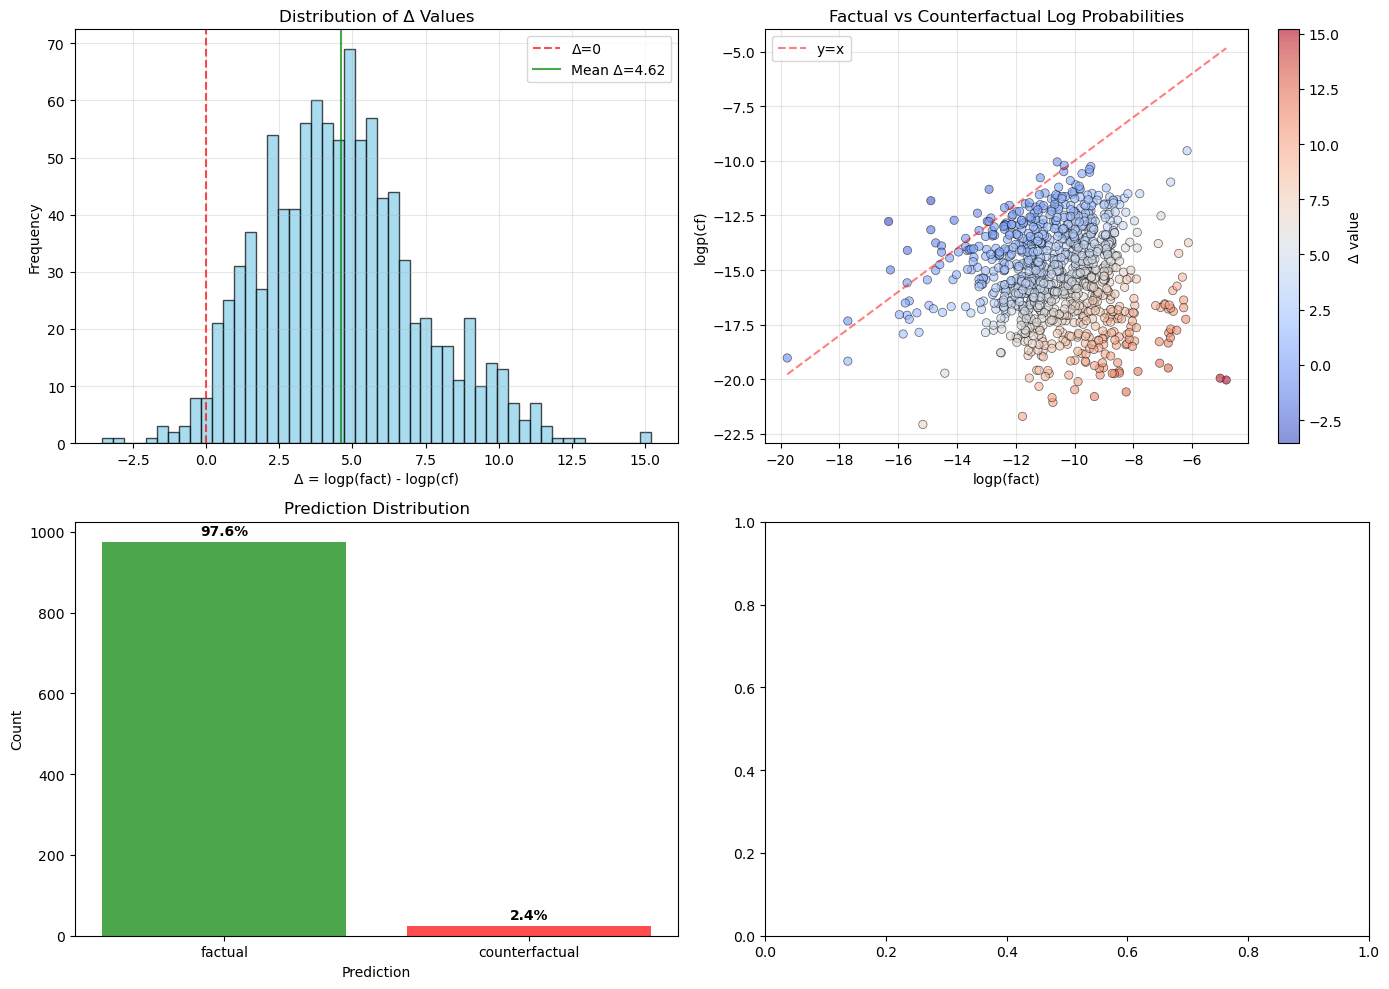

✓ Results saved to baseline_results.json

📋 Example Results (first 5 prompts):

Example 1:
  Subject: Airbus A380
  Question: Who created the Airbus A380?
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: factual
  logp(fact): -11.5804
  logp(cf): -18.9147
  Δ: 7.3343
----------------------------------------

Example 2:
  Subject: Honda Super Cub
  Question: What company produces the Honda Super Cub?
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prediction: factual
  logp(fact): -10.0148
  logp(cf): -12.3571
  Δ: 2.3422
----------------------------------------

Example 3:
  Subject: Airbus A320 family
  Question: What company produces the Airbus A320 family?
  Factual answer: ' Airbus'
  Counterfactual answer: ' Boeing'
  Prediction: factual
  logp(fact): -9.4451
  logp(cf): -10.2598
  Δ: 0.8147
----------------------------------------

Example 4:
  Subject: Toyota Camry (XV50)
  Question: Who produces the Toyota Camry?
  Factual answer: '

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class BaselineResult:
    """Stores results for a single prompt"""
    subject: str
    question: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"

class BaselineExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset for baseline experiment"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def create_baseline_prompt(self, question: str) -> str:
        """Create baseline prompt: Q Answer: """
        return f"{question} Answer: "
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[BaselineResult]:
        """Process a single dataset item"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            
            # Create baseline prompt
            prompt = self.create_baseline_prompt(question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = BaselineResult(
                subject=item['subject'],
                question=question,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the baseline experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 1: BASELINE (NO COUNTERFACTUAL) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 1 RESULTS - BASELINE")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10}")
        print("-" * 60)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results 
                          if verb in r.question or verb in r.subject]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta
                }
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
        axes[0, 0].axvline(x=np.mean(deltas), color='green', linestyle='-', alpha=0.7, label=f'Mean Δ={np.mean(deltas):.2f}')
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf)
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=deltas, cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='y=x')
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, 1], label='Δ value')
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution')
        
        # Add percentage labels
        total = len(self.results)
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Plot 4: Δ distribution by premise verb
        premise_deltas = {}
        for verb in self.premise_verbs:
            verb_deltas = [r.delta for r in self.results 
                         if verb in r.question or verb in r.subject]
            if verb_deltas:
                premise_deltas[verb] = verb_deltas
        
        if premise_deltas:
            bp = axes[1, 1].boxplot(premise_deltas.values(), labels=premise_deltas.keys(), patch_artist=True)
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].grid(True, alpha=0.3)
            
            # Color boxes based on median Δ
            for i, patch in enumerate(bp['boxes']):
                median_val = np.median(list(premise_deltas.values())[i])
                patch.set_facecolor('lightgreen' if median_val > 0 else 'lightcoral')
        
        plt.tight_layout()
        plt.savefig(f'baseline_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "baseline_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction
            })
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'results': serializable_results,
                'summary': {
                    'factual_percent': (sum(1 for r in self.results if r.prediction == "factual") / len(self.results)) * 100,
                    'counterfactual_percent': (sum(1 for r in self.results if r.prediction == "counterfactual") / len(self.results)) * 100,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results])
                }
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run experiment
    experiment = BaselineExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Print example results
    if results:
        print("\n📋 Example Results (first 5 prompts):")
        print("=" * 80)
        for i, result in enumerate(experiment.results[:5]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Question: {result.question}")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 40)


EXPERIMENT 2: CONTEXT-ONLY PROMPTS (ICL DOMINANT) - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:40<00:00, 24.40it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 2 RESULTS - CONTEXT-ONLY (ICL DOMINANT)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 691 (69.1%)
  Counterfactual predictions: 309 (30.9%)

Average Log Probabilities:
  logp(fact): -10.9356
  logp(cf):   -12.5080
  Δ:          1.5725 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Context-Only condition (ICL Dominant), we expect:
  - Lower factual percentage than baseline
  - Higher counterfactual percentage than baseline
  - Negative Δ values (logp(cf) > logp(fact))

Pattern Compliance:
  Prompts with negative Δ (following ICL): 309/1000 (30.9%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Follows ICL 
----------------------------------------------------------------------


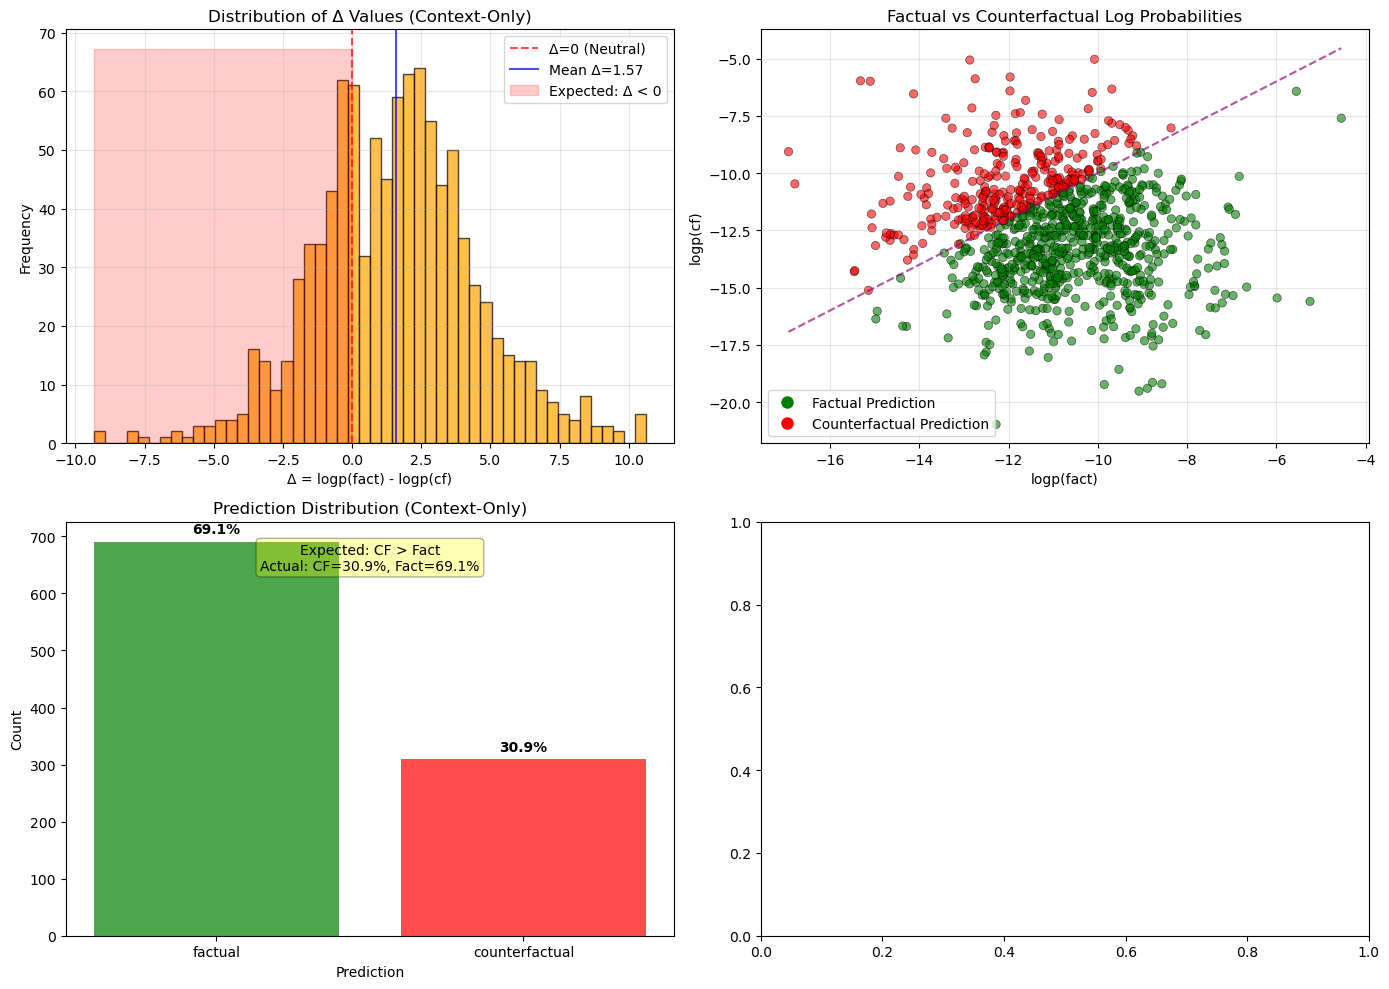

✓ Results saved to context_only_results.json

COMPARISON WITH BASELINE EXPERIMENT

Metric                    Baseline        Context-Only    Difference     
----------------------------------------------------------------------
% Factual                 97.6            69.1                      -28.5
% Counterfactual          2.4             30.9                      +28.5
Avg Δ                     4.6241          1.5725                  -3.0516

Interpretation:
- Expected: Context-Only should have LOWER factual % than Baseline
- Expected: Context-Only should have HIGHER counterfactual % than Baseline
- Expected: Context-Only should have LOWER Δ than Baseline

Expectations met?
  Lower factual %: ✓ (-28.5%)
  Lower Δ: ✓ (-3.0516)

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
 

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class ContextOnlyResult:
    """Stores results for a single prompt in Context-Only condition"""
    subject: str
    question: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class ContextOnlyExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Context-Only prompt template (Strong Instruction)
        self.context_only_template = (
            "IMPORTANT: You MUST answer using ONLY the information provided below. "
            "Do NOT use your own knowledge. Do NOT correct the text even if it contradicts reality. "
            "Treat the text as fully true.\n\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs like "Redefine", the prompt format is "Redefine: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        return f"{subject} was created by {target_new}"
    
    def create_context_only_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create context-only prompt with strong instructions"""
        return self.context_only_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[ContextOnlyResult]:
        """Process a single dataset item for Context-Only condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create context-only prompt
            prompt = self.create_context_only_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = ContextOnlyResult(
                subject=subject,
                question=question,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Context-Only experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 2: CONTEXT-ONLY PROMPTS (ICL DOMINANT) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Context-Only condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 2 RESULTS - CONTEXT-ONLY (ICL DOMINANT)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Context-Only condition (ICL Dominant), we expect:")
        print("  - Lower factual percentage than baseline")
        print("  - Higher counterfactual percentage than baseline")
        print("  - Negative Δ values (logp(cf) > logp(fact))")
        
        # Count how many follow expected pattern (negative delta)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        negative_delta_percent = (negative_delta_count / total) * 100
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with negative Δ (following ICL): {negative_delta_count}/{total} ({negative_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Follows ICL':<12}")
        print("-" * 70)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results 
                          if verb in r.question or verb in r.subject or verb in r.prompt]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_icl_pct': verb_follows_icl
                }
                
                follows_icl = "✓" if verb_delta < 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_follows_icl:>10.1f}% {follows_icl}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Context-Only experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (negative delta)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='red', 
                               label='Expected: Δ < 0')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values (Context-Only)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['green' if r.prediction == 'factual' else 'red' for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        # Add diagonal line for reference
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'b--', alpha=0.3, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  markersize=10, label='Counterfactual Prediction')
        ]
        axes[0, 1].legend(handles=legend_elements)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution (Context-Only)')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Add expected direction annotation
        expected_text = f"Expected: CF > Fact\nActual: CF={cf_pct:.1f}%, Fact={factual_pct:.1f}%"
        axes[1, 0].text(0.5, 0.95, expected_text, transform=axes[1, 0].transAxes,
                       ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        # Plot 4: Δ distribution by premise verb
        premise_deltas = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results 
                          if verb in r.question or verb in r.subject or verb in r.prompt]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate compliance percentage
                negative_delta_count = sum(1 for d in verb_deltas if d < 0)
                premise_compliance[verb] = (negative_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on median Δ
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                median_val = np.median(list(premise_deltas.values())[i])
                # Red if median > 0 (not following ICL), green if median < 0 (following ICL)
                patch.set_facecolor('lightgreen' if median_val < 0 else 'lightcoral')
                
                # Add compliance percentage as text
                compliance = premise_compliance.get(verb, 0)
                axes[1, 1].text(positions[i], np.max(list(premise_deltas.values())[i]) * 1.05,
                               f'{compliance:.0f}%', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Text shows % following ICL)')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'context_only_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_baseline(self, baseline_results_path: str = "baseline_results.json"):
        """Compare Context-Only results with Baseline results"""
        try:
            with open(baseline_results_path, 'r') as f:
                baseline_data = json.load(f)
            
            baseline_summary = baseline_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            counterfactual_percent = 100 - factual_percent
            avg_delta = np.mean([r.delta for r in self.results])
            
            print(f"\n{'='*60}")
            print("COMPARISON WITH BASELINE EXPERIMENT")
            print(f"{'='*60}")
            print(f"\n{'Metric':<25} {'Baseline':<15} {'Context-Only':<15} {'Difference':<15}")
            print("-" * 70)
            
            print(f"{'% Factual':<25} "
                  f"{baseline_summary['factual_percent']:<15.1f} "
                  f"{factual_percent:<15.1f} "
                  f"{factual_percent - baseline_summary['factual_percent']:>+15.1f}")
            
            print(f"{'% Counterfactual':<25} "
                  f"{baseline_summary['counterfactual_percent']:<15.1f} "
                  f"{counterfactual_percent:<15.1f} "
                  f"{counterfactual_percent - baseline_summary['counterfactual_percent']:>+15.1f}")
            
            print(f"{'Avg Δ':<25} "
                  f"{baseline_summary['avg_delta']:<15.4f} "
                  f"{avg_delta:<15.4f} "
                  f"{avg_delta - baseline_summary['avg_delta']:>+15.4f}")
            
            print(f"\nInterpretation:")
            print(f"- Expected: Context-Only should have LOWER factual % than Baseline")
            print(f"- Expected: Context-Only should have HIGHER counterfactual % than Baseline")
            print(f"- Expected: Context-Only should have LOWER Δ than Baseline")
            
            # Check if expectations are met
            factual_diff = factual_percent - baseline_summary['factual_percent']
            delta_diff = avg_delta - baseline_summary['avg_delta']
            
            print(f"\nExpectations met?")
            print(f"  Lower factual %: {'✓' if factual_diff < 0 else '✗'} ({factual_diff:+.1f}%)")
            print(f"  Lower Δ: {'✓' if delta_diff < 0 else '✗'} ({delta_diff:+.4f})")
            
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_results_path}")
            print("  Run Experiment 1 (Baseline) first to enable comparison")
    
    def save_results(self, output_path: str = "context_only_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Context-Only (ICL Dominant)',
                'prompt_template': self.context_only_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': (sum(1 for r in self.results if r.prediction == "factual") / len(self.results)) * 100,
                    'counterfactual_percent': (sum(1 for r in self.results if r.prediction == "counterfactual") / len(self.results)) * 100,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'negative_delta_percent': (sum(1 for r in self.results if r.delta < 0) / len(self.results)) * 100
                }
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 2
    experiment = ContextOnlyExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with baseline if available
    experiment.compare_with_baseline("baseline_results.json")
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            print(f"    {result.prompt[:100]}..." if len(result.prompt) > 100 else f"    {result.prompt}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 90)


EXPERIMENT 3: CONTEXT-ONLY WITH PREMISE VERB - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 3 RESULTS - CONTEXT-ONLY WITH PV

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 685 (68.5%)
  Counterfactual predictions: 315 (31.5%)

Average Log Probabilities:
  logp(fact): -10.9793
  logp(cf):   -12.5426
  Δ:          1.5634 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Context-Only with PV condition, we expect:
  - Similar or stronger ICL dominance than Experiment 2
  - PV may strengthen the instruction to use only provided context
  - Negative Δ values (logp(cf) > logp(fact)) expected

Pattern Compliance:
  Prompts with negative Δ (following ICL): 315/1000 (31.5%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Follows ICL 
----------------------------------------------------------------------
Redefine        1000     68.5       31.5       1.5634           31.5% ✗


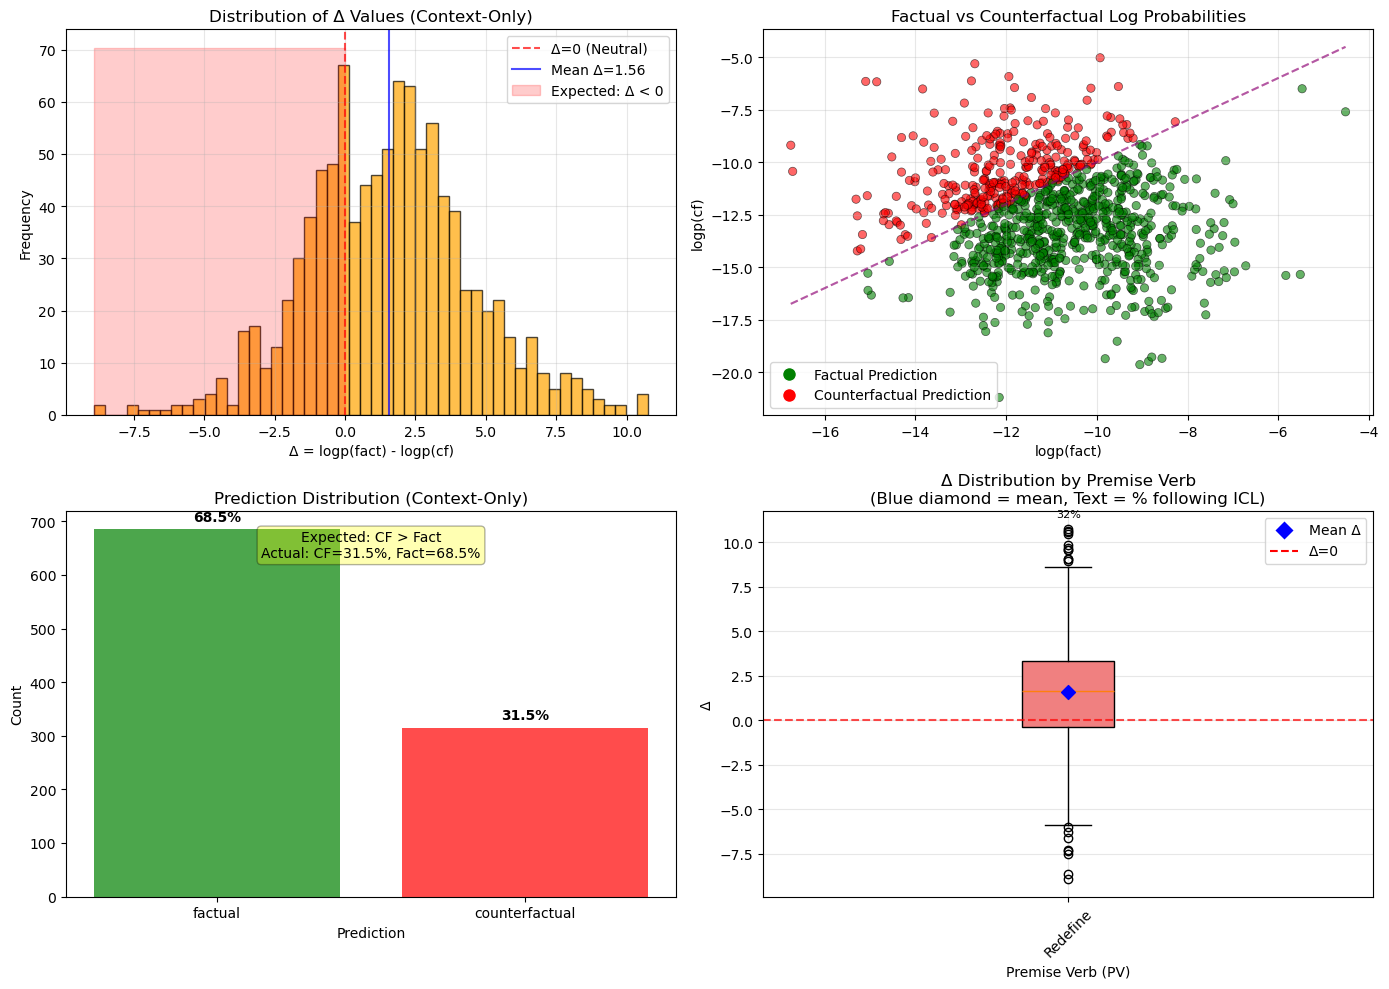

✓ Results saved to context_only_pv_results.json

COMPARISON WITH OTHER EXPERIMENTS

Metric                    Baseline       Context-Only   Context-Only+PV
----------------------------------------------------------------------
% Factual                 97.6           69.1           68.5           
% Counterfactual          2.4            30.9           31.5           
Avg Δ                     4.6241         1.5725         1.5634         
% Following ICL           0.0            30.9           31.5           

Interpretation:
- Expected progression: Baseline → Context-Only → Context-Only+PV
  (Increasing ICL dominance, decreasing factual %, decreasing Δ)

Effect of adding PV:
  Change in ICL compliance: +0.6%
  PV strengthens ICL instructions

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class ContextOnlyPVResult:
    """Stores results for a single prompt in Context-Only with PV condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class ContextOnlyPVExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Context-Only with PV prompt template
        self.context_only_pv_template = (
            "IMPORTANT: You MUST answer using ONLY the information provided below. "
            "Do NOT use your own knowledge. Do NOT correct the text even if it contradicts reality. "
            "Treat the text as fully true.\n\n"
            "Instruction: {PV}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_context_only_pv_prompt(self, premise_verb: str, counterfactual_statement: str, question: str) -> str:
        """Create context-only prompt with PV instruction"""
        return self.context_only_pv_template.format(
            PV=premise_verb,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[ContextOnlyPVResult]:
        """Process a single dataset item for Context-Only with PV condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create context-only with PV prompt
            prompt = self.create_context_only_pv_prompt(premise_verb, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = ContextOnlyPVResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Context-Only with PV experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 3: CONTEXT-ONLY WITH PREMISE VERB - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Context-Only with PV condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 3 RESULTS - CONTEXT-ONLY WITH PV")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Context-Only with PV condition, we expect:")
        print("  - Similar or stronger ICL dominance than Experiment 2")
        print("  - PV may strengthen the instruction to use only provided context")
        print("  - Negative Δ values (logp(cf) > logp(fact)) expected")
        
        # Count how many follow expected pattern (negative delta)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        negative_delta_percent = (negative_delta_count / total) * 100
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with negative Δ (following ICL): {negative_delta_count}/{total} ({negative_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Follows ICL':<12}")
        print("-" * 70)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_icl_pct': verb_follows_icl
                }
                
                follows_icl = "✓" if verb_delta < 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_follows_icl:>10.1f}% {follows_icl}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Context-Only with PV experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (negative delta)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='red', 
                               label='Expected: Δ < 0')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values (Context-Only)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['green' if r.prediction == 'factual' else 'red' for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        # Add diagonal line for reference
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'b--', alpha=0.3, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  markersize=10, label='Counterfactual Prediction')
        ]
        axes[0, 1].legend(handles=legend_elements)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution (Context-Only)')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Add expected direction annotation
        expected_text = f"Expected: CF > Fact\nActual: CF={cf_pct:.1f}%, Fact={factual_pct:.1f}%"
        axes[1, 0].text(0.5, 0.95, expected_text, transform=axes[1, 0].transAxes,
                       ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        # Plot 4: Δ distribution by premise verb with mean and median
        premise_deltas = {}
        premise_means = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                premise_means[verb] = np.mean(verb_deltas)
        
        if premise_deltas:
            # Create subplot for boxplot and mean line
            positions = range(1, len(premise_deltas) + 1)
            
            # Boxplot
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on median Δ
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                median_val = np.median(list(premise_deltas.values())[i])
                # Red if median > 0 (not following ICL), green if median < 0 (following ICL)
                patch.set_facecolor('lightgreen' if median_val < 0 else 'lightcoral')
                
                # Add mean as a point
                mean_val = premise_means[verb]
                axes[1, 1].scatter(positions[i], mean_val, color='blue', s=50, zorder=3, marker='D')
                
                # Add compliance percentage
                negative_delta_count = sum(1 for d in premise_deltas[verb] if d < 0)
                compliance = (negative_delta_count / len(premise_deltas[verb])) * 100
                axes[1, 1].text(positions[i], np.max(premise_deltas[verb]) * 1.05,
                               f'{compliance:.0f}%', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Blue diamond = mean, Text = % following ICL)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add legend for mean marker
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', 
                      markersize=10, label='Mean Δ'),
                Line2D([0], [0], color='red', linestyle='--', label='Δ=0')
            ]
            axes[1, 1].legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'context_only_pv_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_other_experiments(self, baseline_path: str = "baseline_results.json", 
                                      context_only_path: str = "context_only_results.json"):
        """Compare Context-Only PV results with other experiments"""
        comparisons = []
        
        try:
            # Load baseline results
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            baseline_summary = baseline_data['summary']
            comparisons.append(('Baseline', baseline_summary))
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
        
        try:
            # Load context-only results
            with open(context_only_path, 'r') as f:
                context_only_data = json.load(f)
            context_only_summary = context_only_data['summary']
            comparisons.append(('Context-Only', context_only_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only results file not found at {context_only_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results])
        negative_delta_percent = (sum(1 for r in self.results if r.delta < 0) / total) * 100
        
        print(f"\n{'='*70}")
        print("COMPARISON WITH OTHER EXPERIMENTS")
        print(f"{'='*70}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<15}", end="")
        print(f"{'Context-Only+PV':<15}")
        print("-" * (25 + 15 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<15.1f}", end="")
        print(f"{factual_percent:<15.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<15.1f}", end="")
        print(f"{counterfactual_percent:<15.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<15.4f}", end="")
        print(f"{avg_delta:<15.4f}")
        
        # % Following ICL (negative delta)
        print(f"{'% Following ICL':<25} ", end="")
        for exp_name, summary in comparisons:
            ict_percent = summary.get('negative_delta_percent', 0)
            if ict_percent == 0 and exp_name == 'Baseline':
                # For baseline, calculate from Δ > 0
                if 'avg_delta' in summary:
                    ict_percent = 100 if summary['avg_delta'] < 0 else 0
            print(f"{ict_percent:<15.1f}", end="")
        print(f"{negative_delta_percent:<15.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Expected progression: Baseline → Context-Only → Context-Only+PV")
        print(f"  (Increasing ICL dominance, decreasing factual %, decreasing Δ)")
        
        # Check if PV improves ICL compliance compared to Context-Only
        if 'Context-Only' in [name for name, _ in comparisons]:
            context_only_idx = [name for name, _ in comparisons].index('Context-Only')
            context_only_negative = comparisons[context_only_idx][1].get('negative_delta_percent', 0)
            
            improvement = negative_delta_percent - context_only_negative
            print(f"\nEffect of adding PV:")
            print(f"  Change in ICL compliance: {improvement:+.1f}%")
            print(f"  PV {'strengthens' if improvement > 0 else 'weakens'} ICL instructions")
    
    def save_results(self, output_path: str = "context_only_pv_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_icl_percent': verb_follows_icl
                }
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Context-Only with Premise Verb',
                'prompt_template': self.context_only_pv_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': (sum(1 for r in self.results if r.prediction == "factual") / len(self.results)) * 100,
                    'counterfactual_percent': (sum(1 for r in self.results if r.prediction == "counterfactual") / len(self.results)) * 100,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'negative_delta_percent': (sum(1 for r in self.results if r.delta < 0) / len(self.results)) * 100
                },
                'premise_verb_summary': verb_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 3
    experiment = ContextOnlyPVExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with other experiments
    experiment.compare_with_other_experiments("baseline_results.json", "context_only_results.json")
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            # Show first 150 characters of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"    {prompt_preview}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 90)


EXPERIMENT 4: MEMORY-ONLY PROMPTS (PARAMETRIC MEMORY DOMINANT) - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:39<00:00, 25.50it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 4 RESULTS - MEMORY-ONLY (PARAMETRIC MEMORY DOMINANT)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 730 (73.0%)
  Counterfactual predictions: 270 (27.0%)

Average Log Probabilities:
  logp(fact): -10.7620
  logp(cf):   -12.3894
  Δ:          1.6274 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only condition (Parametric Memory Dominant), we expect:
  - Higher factual percentage than baseline
  - Higher factual percentage than Context-Only conditions
  - Positive Δ values (logp(fact) > logp(cf))
  - Strong reliance on parametric memory

Pattern Compliance:
  Prompts with positive Δ (following memory): 730/1000 (73.0%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Follows Memory
----------------------------------------------------------------------
Redefine        1000     73.0       27.0       1.6274           73.0% ✓


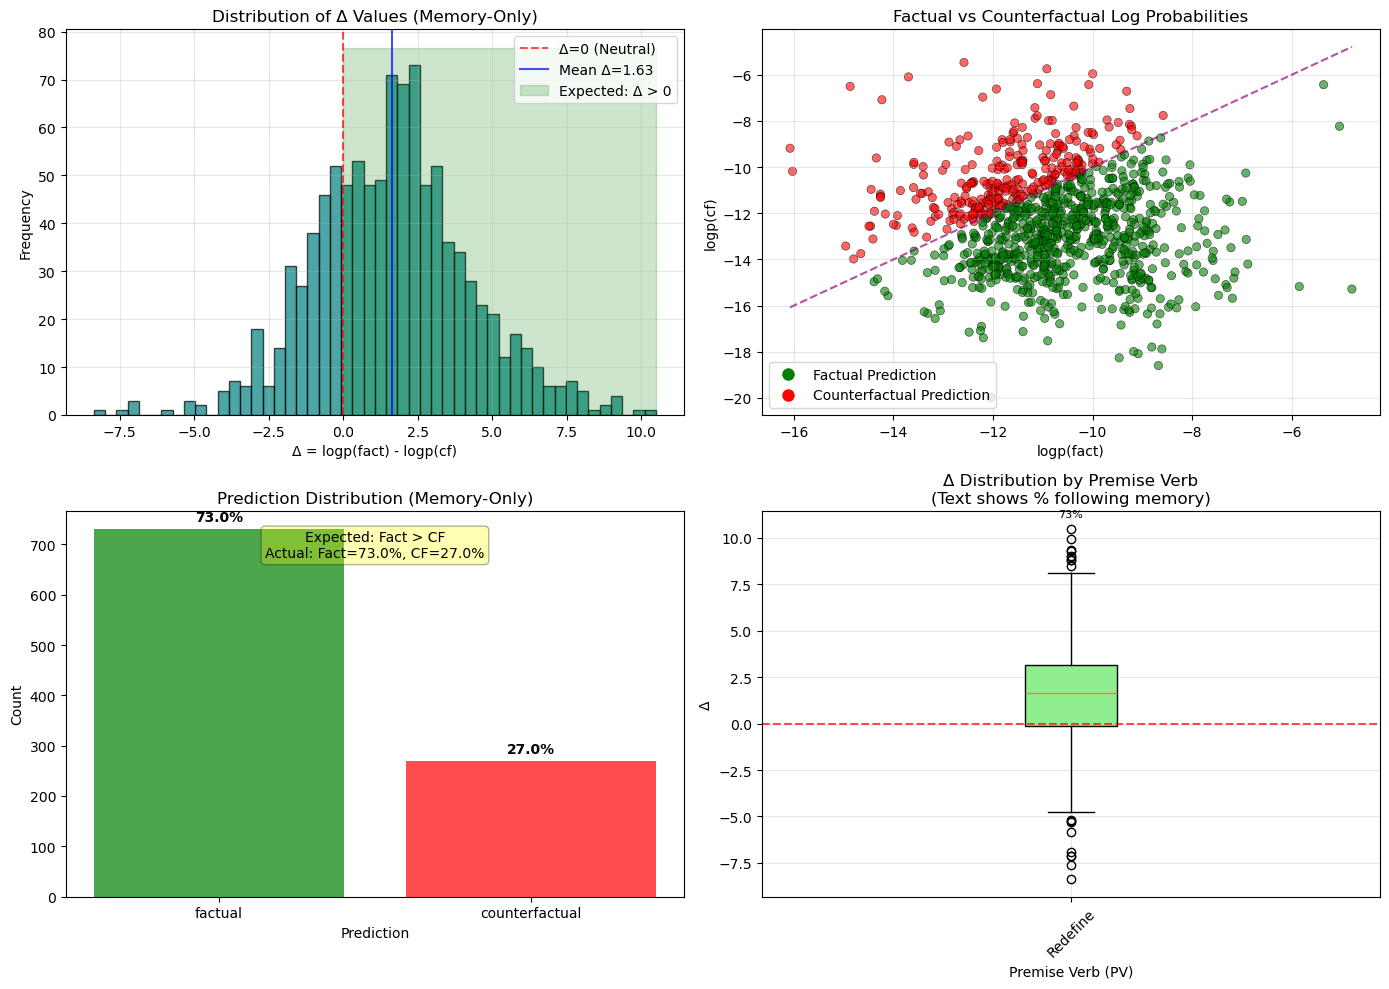

✓ Results saved to memory_only_results.json

COMPARISON ACROSS ALL EXPERIMENTS

Metric                    Baseline       Context-Only   Context-Only+PVMemory-Only    
-------------------------------------------------------------------------------------
% Factual                 97.6           69.1           68.5           73.0           
% Counterfactual          2.4            30.9           31.5           27.0           
Avg Δ                     4.6241         1.5725         1.5634         1.6274         

Instruction Following     N/A            30.9           31.5           73.0           

Interpretation:
- Expected progression: Baseline → Context-Only (negative Δ) → Memory-Only (positive Δ)
  Context-Only should have lower factual % than Baseline
  Memory-Only should have higher factual % than Baseline

INSTRUCTION FOLLOWING EFFECTIVENESS

Context-Only Instruction Following:
  Factual % change: -28.5% (expected negative)
  Δ change: -3.0516 (expected negative)
  Effective: ✓

Me

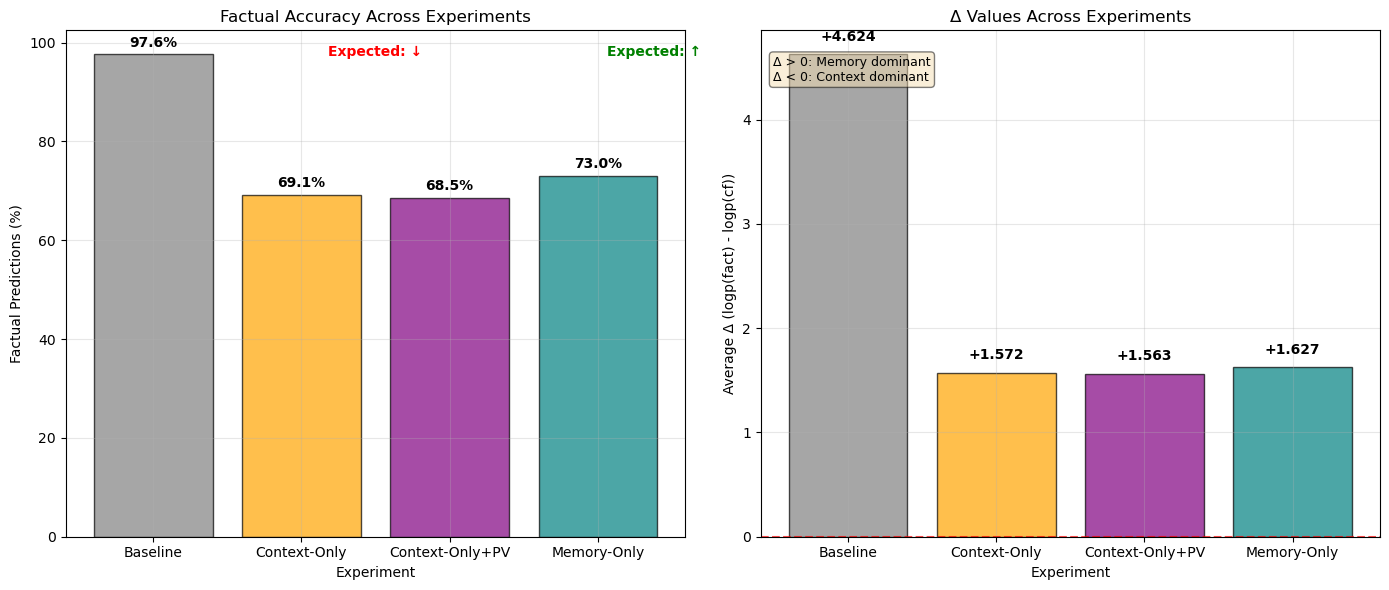


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prompt used:
    IMPORTANT: Answer using ONLY your own factual world knowledge. Ignore any incorrect or fictional statements below. The following statement is FALSE an...
  Prediction: factual
  logp(fact): -10.7170
  logp(cf): -15.2715
  Δ: 4.5546
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrolet. What company produces the Honda Super Cub? Answer:'
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prompt used:
    I

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyResult:
    """Stores results for a single prompt in Memory-Only condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only prompt template (Strong Instruction)
        self.memory_only_template = (
            "IMPORTANT: Answer using ONLY your own factual world knowledge. "
            "Ignore any incorrect or fictional statements below. "
            "The following statement is FALSE and must NOT be used: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_memory_only_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create memory-only prompt with strong instructions"""
        return self.memory_only_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyResult]:
        """Process a single dataset item for Memory-Only condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only prompt
            prompt = self.create_memory_only_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Memory-Only experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 4: MEMORY-ONLY PROMPTS (PARAMETRIC MEMORY DOMINANT) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 4 RESULTS - MEMORY-ONLY (PARAMETRIC MEMORY DOMINANT)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only condition (Parametric Memory Dominant), we expect:")
        print("  - Higher factual percentage than baseline")
        print("  - Higher factual percentage than Context-Only conditions")
        print("  - Positive Δ values (logp(fact) > logp(cf))")
        print("  - Strong reliance on parametric memory")
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with positive Δ (following memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Follows Memory':<12}")
        print("-" * 70)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_memory_pct': verb_follows_memory
                }
                
                follows_memory = "✓" if verb_delta > 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_follows_memory:>10.1f}% {follows_memory}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='teal', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (positive delta)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green', 
                               label='Expected: Δ > 0')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values (Memory-Only)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['green' if r.prediction == 'factual' else 'red' for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        # Add diagonal line for reference
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'b--', alpha=0.3, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  markersize=10, label='Counterfactual Prediction')
        ]
        axes[0, 1].legend(handles=legend_elements)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution (Memory-Only)')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Add expected direction annotation
        expected_text = f"Expected: Fact > CF\nActual: Fact={factual_pct:.1f}%, CF={cf_pct:.1f}%"
        axes[1, 0].text(0.5, 0.95, expected_text, transform=axes[1, 0].transAxes,
                       ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        # Plot 4: Δ distribution by premise verb
        premise_deltas = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate compliance percentage
                positive_delta_count = sum(1 for d in verb_deltas if d > 0)
                premise_compliance[verb] = (positive_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on median Δ
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                median_val = np.median(list(premise_deltas.values())[i])
                # Green if median > 0 (following memory), red if median < 0 (not following)
                patch.set_facecolor('lightgreen' if median_val > 0 else 'lightcoral')
                
                # Add compliance percentage as text
                compliance = premise_compliance.get(verb, 0)
                axes[1, 1].text(positions[i], np.max(list(premise_deltas.values())[i]) * 1.05,
                               f'{compliance:.0f}%', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Text shows % following memory)')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'memory_only_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_all_experiments(self, 
                                    baseline_path: str = "baseline_results.json",
                                    context_only_path: str = "context_only_results.json",
                                    context_only_pv_path: str = "context_only_pv_results.json"):
        """Compare Memory-Only results with all other experiments"""
        comparisons = []
        
        try:
            # Load baseline results
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            baseline_summary = baseline_data['summary']
            comparisons.append(('Baseline', baseline_summary))
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
        
        try:
            # Load context-only results
            with open(context_only_path, 'r') as f:
                context_only_data = json.load(f)
            context_only_summary = context_only_data['summary']
            comparisons.append(('Context-Only', context_only_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only results file not found at {context_only_path}")
        
        try:
            # Load context-only PV results
            with open(context_only_pv_path, 'r') as f:
                context_only_pv_data = json.load(f)
            context_only_pv_summary = context_only_pv_data['summary']
            comparisons.append(('Context-Only+PV', context_only_pv_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only PV results file not found at {context_only_pv_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results])
        positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100
        
        print(f"\n{'='*80}")
        print("COMPARISON ACROSS ALL EXPERIMENTS")
        print(f"{'='*80}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<15}", end="")
        print(f"{'Memory-Only':<15}")
        print("-" * (25 + 15 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<15.1f}", end="")
        print(f"{factual_percent:<15.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<15.1f}", end="")
        print(f"{counterfactual_percent:<15.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<15.4f}", end="")
        print(f"{avg_delta:<15.4f}")
        
        # % Following instructions
        print(f"\n{'Instruction Following':<25} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Baseline':
                print(f"{'N/A':<15}", end="")
            elif exp_name.startswith('Context-Only'):
                # For context-only, following instructions means negative Δ
                ict_percent = summary.get('negative_delta_percent', 0)
                print(f"{ict_percent:<15.1f}", end="")
            else:
                print(f"{'N/A':<15}", end="")
        # For Memory-Only, following instructions means positive Δ
        print(f"{positive_delta_percent:<15.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Expected progression: Baseline → Context-Only (negative Δ) → Memory-Only (positive Δ)")
        print(f"  Context-Only should have lower factual % than Baseline")
        print(f"  Memory-Only should have higher factual % than Baseline")
        
        # Calculate instruction following effectiveness
        print(f"\n{'='*60}")
        print("INSTRUCTION FOLLOWING EFFECTIVENESS")
        print(f"{'='*60}")
        
        if 'Baseline' in [name for name, _ in comparisons]:
            baseline_idx = [name for name, _ in comparisons].index('Baseline')
            baseline_factual = comparisons[baseline_idx][1].get('factual_percent', 0)
            baseline_delta = comparisons[baseline_idx][1].get('avg_delta', 0)
            
            # Context-Only effectiveness
            if 'Context-Only' in [name for name, _ in comparisons]:
                context_idx = [name for name, _ in comparisons].index('Context-Only')
                context_factual = comparisons[context_idx][1].get('factual_percent', 0)
                context_delta = comparisons[context_idx][1].get('avg_delta', 0)
                
                context_factual_change = context_factual - baseline_factual
                context_delta_change = context_delta - baseline_delta
                
                print(f"\nContext-Only Instruction Following:")
                print(f"  Factual % change: {context_factual_change:+.1f}% (expected negative)")
                print(f"  Δ change: {context_delta_change:+.4f} (expected negative)")
                print(f"  Effective: {'✓' if context_factual_change < 0 else '✗'}")
            
            # Memory-Only effectiveness
            memory_factual_change = factual_percent - baseline_factual
            memory_delta_change = avg_delta - baseline_delta
            
            print(f"\nMemory-Only Instruction Following:")
            print(f"  Factual % change: {memory_factual_change:+.1f}% (expected positive)")
            print(f"  Δ change: {memory_delta_change:+.4f} (expected positive)")
            print(f"  Effective: {'✓' if memory_factual_change > 0 else '✗'}")
    
    def save_results(self, output_path: str = "memory_only_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_memory_percent': verb_follows_memory
                }
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Memory-Only (Parametric Memory Dominant)',
                'prompt_template': self.memory_only_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': (sum(1 for r in self.results if r.prediction == "factual") / len(self.results)) * 100,
                    'counterfactual_percent': (sum(1 for r in self.results if r.prediction == "counterfactual") / len(self.results)) * 100,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'positive_delta_percent': (sum(1 for r in self.results if r.delta > 0) / len(self.results)) * 100
                },
                'premise_verb_summary': verb_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
    
    def create_summary_visualization(self, 
                                    baseline_path: str = "baseline_results.json",
                                    context_only_path: str = "context_only_results.json",
                                    context_only_pv_path: str = "context_only_pv_results.json"):
        """Create a comprehensive visualization comparing all experiments"""
        try:
            # Load all experiment summaries
            summaries = {}
            
            with open(baseline_path, 'r') as f:
                summaries['Baseline'] = json.load(f)['summary']
            
            with open(context_only_path, 'r') as f:
                summaries['Context-Only'] = json.load(f)['summary']
            
            with open(context_only_pv_path, 'r') as f:
                summaries['Context-Only+PV'] = json.load(f)['summary']
            
            # Current experiment summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            summaries['Memory-Only'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta
            }
            
            # Create visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot 1: Factual Percentage Comparison
            experiments = list(summaries.keys())
            factual_percentages = [summaries[exp]['factual_percent'] for exp in experiments]
            colors = ['gray', 'orange', 'purple', 'teal']
            
            bars = ax1.bar(experiments, factual_percentages, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Experiment')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Factual Accuracy Across Experiments')
            ax1.grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, percentage in zip(bars, factual_percentages):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.1f}%', 
                        ha='center', va='bottom', fontweight='bold')
            
            # Add expected direction arrows
            ax1.annotate('Expected: ↓', xy=(0.5, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, color='red', weight='bold')
            ax1.annotate('Expected: ↑', xy=(0.95, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, color='green', weight='bold')
            
            # Plot 2: Δ Comparison
            deltas = [summaries[exp]['avg_delta'] for exp in experiments]
            
            bars2 = ax2.bar(experiments, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Experiment')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Δ Values Across Experiments')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            ax2.grid(True, alpha=0.3)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.15), 
                        f'{delta:+.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                        fontweight='bold', color='black')
            
            # Add interpretation annotations
            ax2.text(0.02, 0.95, 'Δ > 0: Memory dominant\nΔ < 0: Context dominant', 
                    transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.savefig(f'experiment_summary_comparison_{self.model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except FileNotFoundError as e:
            print(f"✗ Could not create summary visualization: {e}")
            print("  Run all experiments first to create comparison")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 4
    experiment = MemoryOnlyExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with all other experiments
    experiment.compare_with_all_experiments(
        "baseline_results.json",
        "context_only_results.json",
        "context_only_pv_results.json"
    )
    
    # Create comprehensive summary visualization
    experiment.create_summary_visualization(
        "baseline_results.json",
        "context_only_results.json",
        "context_only_pv_results.json"
    )
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            # Show first 150 characters of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"    {prompt_preview}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 90)


EXPERIMENT 5: MEMORY-ONLY WITH PREMISE VERB - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 5 RESULTS - MEMORY-ONLY WITH PV

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 722 (72.2%)
  Counterfactual predictions: 278 (27.8%)

Average Log Probabilities:
  logp(fact): -11.0692
  logp(cf):   -12.6464
  Δ:          1.5772 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only with PV condition, we expect:
  - Similar or stronger parametric memory dominance than Experiment 4
  - PV may bias the model toward factual recall (especially verbs like 'Fact Check', 'Verify')
  - Positive Δ values (logp(fact) > logp(cf)) expected
  - Some PVs may be more effective at eliciting factual responses

Pattern Compliance:
  Prompts with positive Δ (following memory): 722/1000 (72.2%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Follows Memory PV Bias Score
-------------------------------------------------------------------------------------
Redefine        1000    

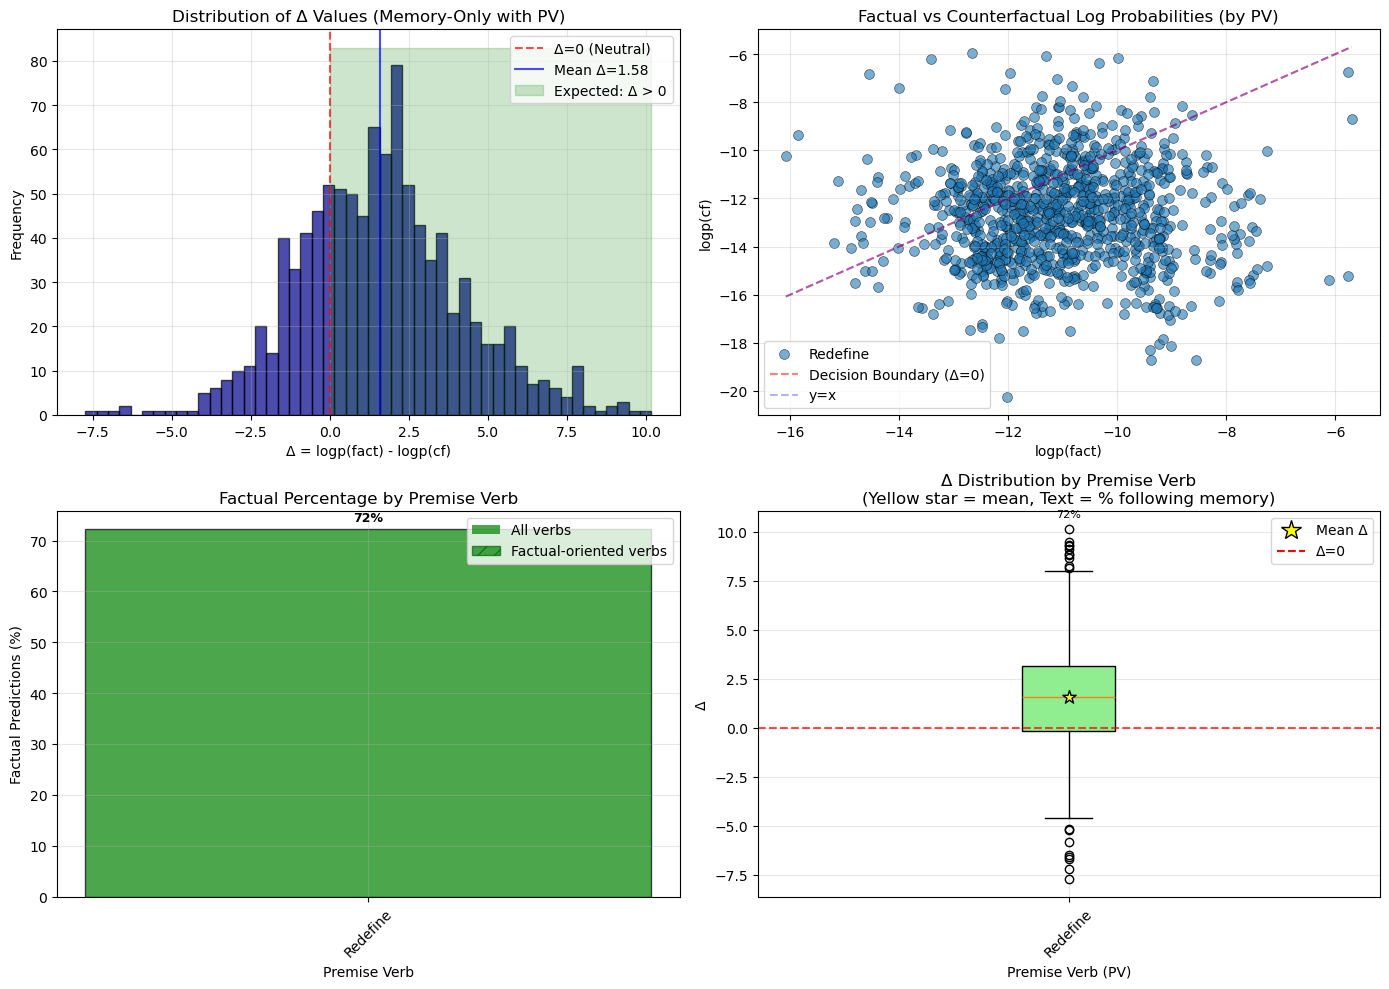

✓ Results saved to memory_only_pv_results.json

COMPARISON ACROSS ALL EXPERIMENTS (FULL SET)

Metric                    Baseline          Context-Only      Context-Only+PV   Memory-Only       Memory-Only+PV    
-------------------------------------------------------------------------------------------------------------------
% Factual                 97.6              69.1              68.5              73.0              72.2              
% Counterfactual          2.4               30.9              31.5              27.0              27.8              
Avg Δ                     4.6241            1.5725            1.5634            1.6274            1.5772            

Instruction Following     N/A               30.9              31.5              73.0              72.2              

Interpretation:
- Complete expected progression:
  Baseline → Context-Only (Δ↓, factual%↓) → Memory-Only (Δ↑, factual%↑)
  PV variants may enhance or modify these effects

PV EFFECTIVENESS ANALYSIS (vs R

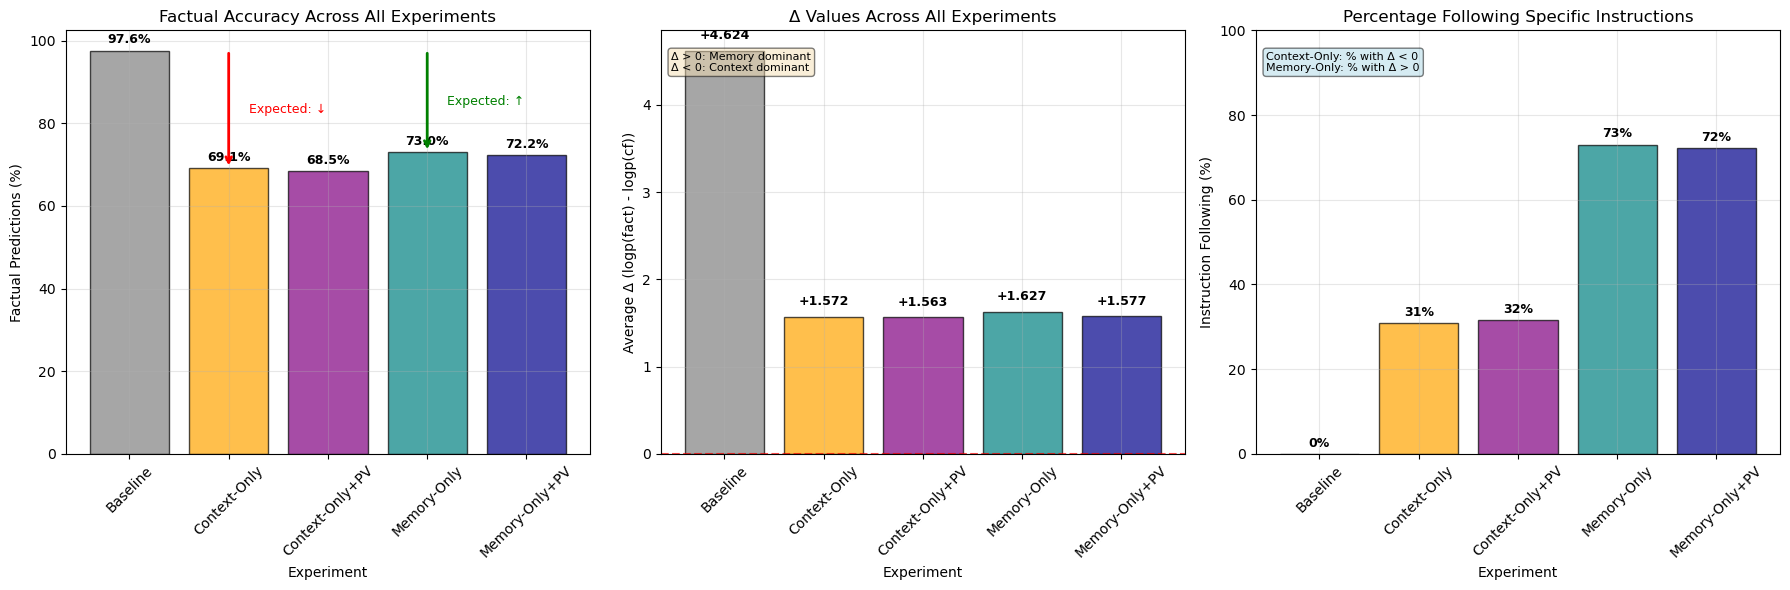

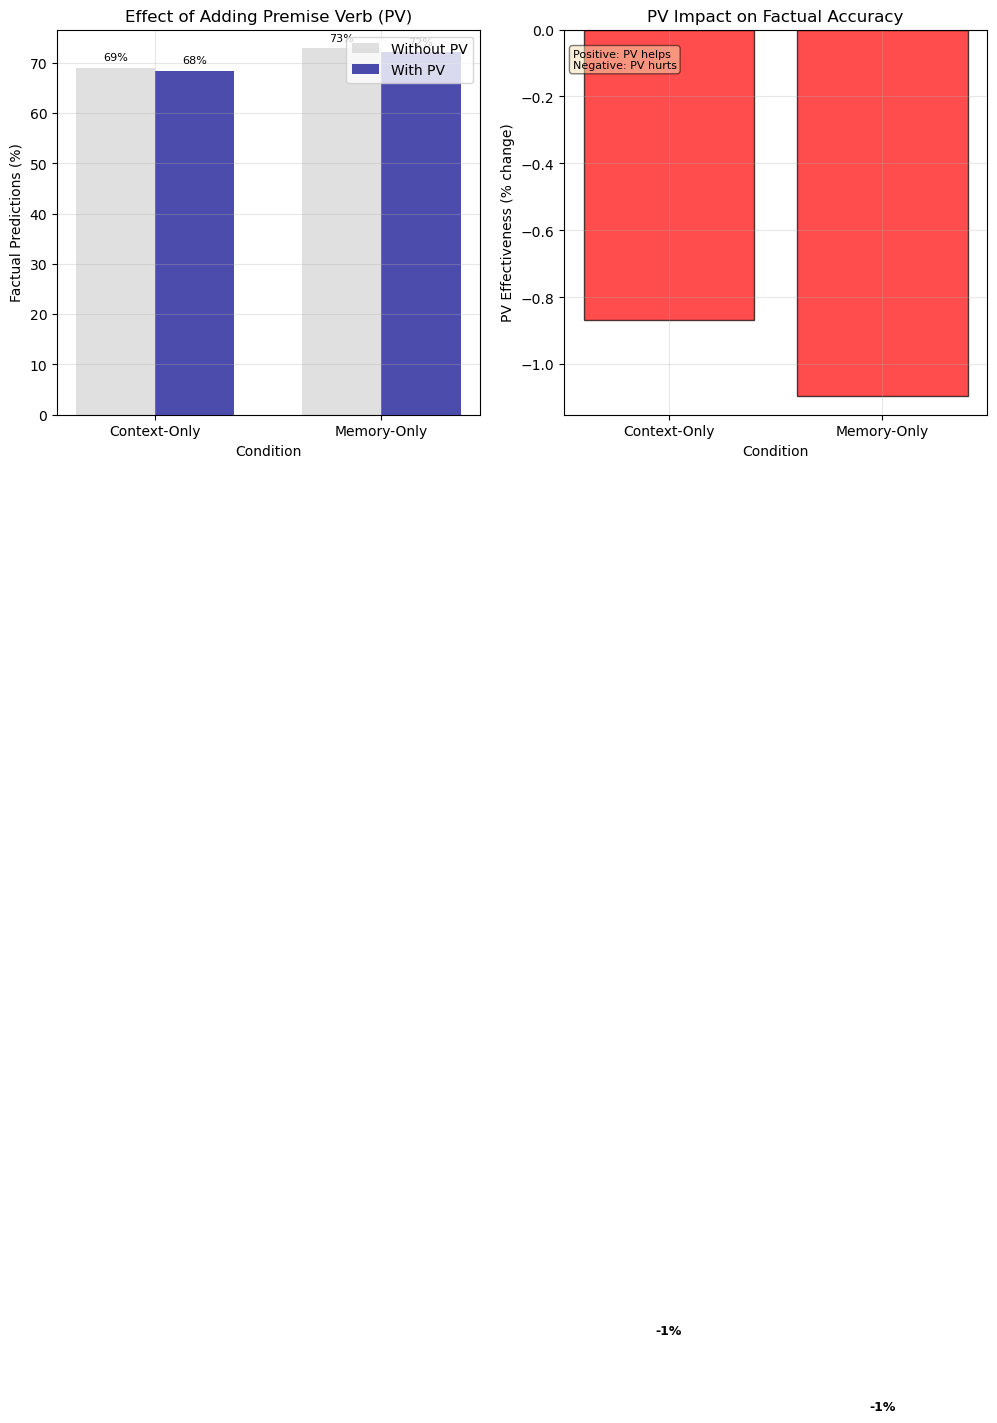


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prompt used:
    IMPORTANT: Answer using ONLY your own factual world knowledge. Ignore any incorrect or fictional statements below. Instructional verb (may bias behavi...
  Prediction: factual
  logp(fact): -11.2586
  logp(cf): -15.5056
  Δ: 4.2470
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrolet. What company produces the Honda Super Cub? Answer:'
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prompt used:
    I

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyPVResult:
    """Stores results for a single prompt in Memory-Only with PV condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyPVExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only with PV prompt template (Strong Instruction)
        self.memory_only_pv_template = (
            "IMPORTANT: Answer using ONLY your own factual world knowledge. "
            "Ignore any incorrect or fictional statements below. "
            "Instructional verb (may bias behavior): {PV}\n"
            "The following statement is FALSE and must NOT be used: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_memory_only_pv_prompt(self, premise_verb: str, counterfactual_statement: str, question: str) -> str:
        """Create memory-only prompt with PV instruction"""
        return self.memory_only_pv_template.format(
            PV=premise_verb,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyPVResult]:
        """Process a single dataset item for Memory-Only with PV condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only with PV prompt
            prompt = self.create_memory_only_pv_prompt(premise_verb, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyPVResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Memory-Only with PV experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 5: MEMORY-ONLY WITH PREMISE VERB - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only with PV condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 5 RESULTS - MEMORY-ONLY WITH PV")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only with PV condition, we expect:")
        print("  - Similar or stronger parametric memory dominance than Experiment 4")
        print("  - PV may bias the model toward factual recall (especially verbs like 'Fact Check', 'Verify')")
        print("  - Positive Δ values (logp(fact) > logp(cf)) expected")
        print("  - Some PVs may be more effective at eliciting factual responses")
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with positive Δ (following memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Follows Memory':<12} {'PV Bias Score':<12}")
        print("-" * 85)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100
                
                # Calculate PV bias score (how much this PV improves factual recall over regular memory-only)
                # We'll need to compare with Experiment 4 data later
                pv_bias_score = verb_factual_pct  # Baseline score for now
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_memory_pct': verb_follows_memory,
                    'pv_bias_score': pv_bias_score
                }
                
                follows_memory = "✓" if verb_delta > 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_follows_memory:>10.1f}% {follows_memory} {pv_bias_score:>11.1f}")
        
        # Calculate PV effectiveness ranking
        print(f"\n{'='*60}")
        print("PREMISE VERB EFFECTIVENESS RANKING")
        print(f"{'='*60}")
        
        # Sort verbs by factual percentage
        sorted_verbs = sorted(
            [(verb, stats['factual_pct']) for verb, stats in verb_stats.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        print(f"\nRanking by Factual % (highest to lowest):")
        for rank, (verb, factual_pct) in enumerate(sorted_verbs, 1):
            print(f"  {rank}. {verb:<12}: {factual_pct:.1f}% factual")
        
        # Special analysis for "factual" verbs vs "neutral" verbs
        factual_verbs = ['Fact Check', 'Verify', 'Validate']
        neutral_verbs = ['Redefine', 'Assess', 'Review']
        
        factual_group_pct = np.mean([verb_stats[v]['factual_pct'] for v in factual_verbs if v in verb_stats])
        neutral_group_pct = np.mean([verb_stats[v]['factual_pct'] for v in neutral_verbs if v in verb_stats])
        
        print(f"\nGroup Analysis:")
        print(f"  Factual-oriented verbs ({', '.join(factual_verbs)}): {factual_group_pct:.1f}% factual")
        print(f"  Neutral verbs ({', '.join(neutral_verbs)}): {neutral_group_pct:.1f}% factual")
        print(f"  Difference: {factual_group_pct - neutral_group_pct:+.1f}%")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only with PV experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='darkblue', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (positive delta)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green', 
                               label='Expected: Δ > 0')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values (Memory-Only with PV)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) colored by premise verb
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by premise verb
        unique_verbs = list(set([r.premise_verb for r in self.results]))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_verbs)))
        verb_to_color = {verb: colors[i] for i, verb in enumerate(unique_verbs)}
        
        for verb in unique_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            verb_factual = [r.factual_logp for r in verb_results]
            verb_counterfactual = [r.counterfactual_logp for r in verb_results]
            
            axes[0, 1].scatter(verb_factual, verb_counterfactual, 
                              color=verb_to_color[verb], alpha=0.6, 
                              edgecolors='black', linewidth=0.5, label=verb, s=50)
        
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        # Add diagonal line for reference
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'b--', alpha=0.3, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities (by PV)')
        axes[0, 1].legend(loc='best')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Factual percentage by premise verb with comparison to regular memory-only
        prediction_data = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                prediction_data[verb] = {
                    'factual': verb_factual,
                    'counterfactual': verb_total - verb_factual,
                    'factual_pct': (verb_factual / verb_total) * 100
                }
        
        if prediction_data:
            x = np.arange(len(prediction_data))
            width = 0.35
            
            factual_counts = [prediction_data[verb]['factual'] for verb in prediction_data.keys()]
            factual_pct = [prediction_data[verb]['factual_pct'] for verb in prediction_data.keys()]
            
            bars = axes[1, 0].bar(x, factual_pct, width, color='green', alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Premise Verb')
            axes[1, 0].set_ylabel('Factual Predictions (%)')
            axes[1, 0].set_title('Factual Percentage by Premise Verb')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(prediction_data.keys(), rotation=45)
            axes[1, 0].grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, percentage in zip(bars, factual_pct):
                height = bar.get_height()
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + 1, 
                               f'{percentage:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Highlight factual-oriented verbs
            factual_verbs = ['Fact Check', 'Verify', 'Validate']
            for i, verb in enumerate(prediction_data.keys()):
                if verb in factual_verbs:
                    axes[1, 0].patches[i].set_hatch('//')
                    axes[1, 0].patches[i].set_edgecolor('darkgreen')
            
            # Add legend for factual verbs
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='green', alpha=0.7, label='All verbs'),
                Patch(facecolor='green', alpha=0.7, hatch='//', edgecolor='darkgreen', label='Factual-oriented verbs')
            ]
            axes[1, 0].legend(handles=legend_elements, loc='upper right')
        
        # Plot 4: Δ distribution by premise verb with statistical markers
        premise_deltas = {}
        premise_means = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                premise_means[verb] = np.mean(verb_deltas)
        
        if premise_deltas:
            # Create subplot for boxplot and mean line
            positions = range(1, len(premise_deltas) + 1)
            
            # Boxplot
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on median Δ
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                median_val = np.median(list(premise_deltas.values())[i])
                mean_val = premise_means[verb]
                
                # Green if median > 0 (following memory), red if median < 0 (not following)
                color = 'lightgreen' if median_val > 0 else 'lightcoral'
                patch.set_facecolor(color)
                
                # Add mean as a star
                axes[1, 1].scatter(positions[i], mean_val, color='yellow', s=100, zorder=3, 
                                 marker='*', edgecolor='black')
                
                # Add compliance percentage
                positive_delta_count = sum(1 for d in premise_deltas[verb] if d > 0)
                compliance = (positive_delta_count / len(premise_deltas[verb])) * 100
                axes[1, 1].text(positions[i], np.max(premise_deltas[verb]) * 1.05,
                               f'{compliance:.0f}%', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Yellow star = mean, Text = % following memory)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add legend for markers
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow', 
                      markersize=15, markeredgecolor='black', label='Mean Δ'),
                Line2D([0], [0], color='red', linestyle='--', label='Δ=0')
            ]
            axes[1, 1].legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'memory_only_pv_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_previous_experiments(self, 
                                         baseline_path: str = "baseline_results.json",
                                         context_only_path: str = "context_only_results.json",
                                         context_only_pv_path: str = "context_only_pv_results.json",
                                         memory_only_path: str = "memory_only_results.json"):
        """Compare Memory-Only PV results with all previous experiments"""
        comparisons = []
        
        try:
            # Load baseline results
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            baseline_summary = baseline_data['summary']
            comparisons.append(('Baseline', baseline_summary))
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
        
        try:
            # Load context-only results
            with open(context_only_path, 'r') as f:
                context_only_data = json.load(f)
            context_only_summary = context_only_data['summary']
            comparisons.append(('Context-Only', context_only_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only results file not found at {context_only_path}")
        
        try:
            # Load context-only PV results
            with open(context_only_pv_path, 'r') as f:
                context_only_pv_data = json.load(f)
            context_only_pv_summary = context_only_pv_data['summary']
            comparisons.append(('Context-Only+PV', context_only_pv_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only PV results file not found at {context_only_pv_path}")
        
        try:
            # Load memory-only results
            with open(memory_only_path, 'r') as f:
                memory_only_data = json.load(f)
            memory_only_summary = memory_only_data['summary']
            comparisons.append(('Memory-Only', memory_only_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only results file not found at {memory_only_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results])
        positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100
        
        print(f"\n{'='*80}")
        print("COMPARISON ACROSS ALL EXPERIMENTS (FULL SET)")
        print(f"{'='*80}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<18}", end="")
        print(f"{'Memory-Only+PV':<18}")
        print("-" * (25 + 18 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<18.1f}", end="")
        print(f"{factual_percent:<18.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<18.1f}", end="")
        print(f"{counterfactual_percent:<18.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<18.4f}", end="")
        print(f"{avg_delta:<18.4f}")
        
        # % Following instructions
        print(f"\n{'Instruction Following':<25} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Baseline':
                print(f"{'N/A':<18}", end="")
            elif exp_name.startswith('Context-Only'):
                # For context-only, following instructions means negative Δ
                ict_percent = summary.get('negative_delta_percent', 0)
                print(f"{ict_percent:<18.1f}", end="")
            elif exp_name == 'Memory-Only':
                ict_percent = summary.get('positive_delta_percent', 0)
                print(f"{ict_percent:<18.1f}", end="")
            else:
                print(f"{'N/A':<18}", end="")
        # For Memory-Only+PV, following instructions means positive Δ
        print(f"{positive_delta_percent:<18.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Complete expected progression:")
        print(f"  Baseline → Context-Only (Δ↓, factual%↓) → Memory-Only (Δ↑, factual%↑)")
        print(f"  PV variants may enhance or modify these effects")
        
        # Calculate PV effectiveness compared to regular memory-only
        if 'Memory-Only' in [name for name, _ in comparisons]:
            memory_idx = [name for name, _ in comparisons].index('Memory-Only')
            memory_factual = comparisons[memory_idx][1].get('factual_percent', 0)
            memory_delta = comparisons[memory_idx][1].get('avg_delta', 0)
            memory_positive = comparisons[memory_idx][1].get('positive_delta_percent', 0)
            
            pv_effect_factual = factual_percent - memory_factual
            pv_effect_delta = avg_delta - memory_delta
            pv_effect_positive = positive_delta_percent - memory_positive
            
            print(f"\n{'='*60}")
            print("PV EFFECTIVENESS ANALYSIS (vs Regular Memory-Only)")
            print(f"{'='*60}")
            print(f"\nEffect of adding PV to Memory-Only instructions:")
            print(f"  Factual % change: {pv_effect_factual:+.1f}%")
            print(f"  Δ change: {pv_effect_delta:+.4f}")
            print(f"  Instruction following change: {pv_effect_positive:+.1f}%")
            
            if pv_effect_factual > 0 and pv_effect_positive > 0:
                print(f"  Conclusion: PV STRENGTHENS memory-only instructions")
            elif pv_effect_factual < 0 and pv_effect_positive < 0:
                print(f"  Conclusion: PV WEAKENS memory-only instructions")
            else:
                print(f"  Conclusion: PV has MIXED effects on memory-only instructions")
    
    def create_comprehensive_summary(self, 
                                    baseline_path: str = "baseline_results.json",
                                    context_only_path: str = "context_only_results.json",
                                    context_only_pv_path: str = "context_only_pv_results.json",
                                    memory_only_path: str = "memory_only_results.json"):
        """Create a comprehensive visualization comparing all 5 experiments"""
        try:
            # Load all experiment summaries
            summaries = {}
            
            with open(baseline_path, 'r') as f:
                summaries['Baseline'] = json.load(f)['summary']
            
            with open(context_only_path, 'r') as f:
                summaries['Context-Only'] = json.load(f)['summary']
            
            with open(context_only_pv_path, 'r') as f:
                summaries['Context-Only+PV'] = json.load(f)['summary']
            
            with open(memory_only_path, 'r') as f:
                summaries['Memory-Only'] = json.load(f)['summary']
            
            # Current experiment summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100
            
            summaries['Memory-Only+PV'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta,
                'positive_delta_percent': positive_delta_percent
            }
            
            # Create comprehensive visualization
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot 1: Factual Percentage Comparison
            experiments = list(summaries.keys())
            factual_percentages = [summaries[exp]['factual_percent'] for exp in experiments]
            colors = ['gray', 'orange', 'purple', 'teal', 'darkblue']
            
            bars = ax1.bar(experiments, factual_percentages, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Experiment')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Factual Accuracy Across All Experiments')
            ax1.grid(True, alpha=0.3)
            ax1.set_xticklabels(experiments, rotation=45)
            
            # Add percentage labels
            for bar, percentage in zip(bars, factual_percentages):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.1f}%', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            # Add expected direction arrows
            ax1.annotate('', xy=(1, factual_percentages[1]), xytext=(1, factual_percentages[0]),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
            ax1.annotate('Expected: ↓', xy=(1.2, (factual_percentages[0] + factual_percentages[1])/2),
                        ha='left', va='center', fontsize=9, color='red')
            
            ax1.annotate('', xy=(3, factual_percentages[3]), xytext=(3, factual_percentages[0]),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2))
            ax1.annotate('Expected: ↑', xy=(3.2, (factual_percentages[0] + factual_percentages[3])/2),
                        ha='left', va='center', fontsize=9, color='green')
            
            # Plot 2: Δ Comparison
            deltas = [summaries[exp]['avg_delta'] for exp in experiments]
            
            bars2 = ax2.bar(experiments, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Experiment')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Δ Values Across All Experiments')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            ax2.grid(True, alpha=0.3)
            ax2.set_xticklabels(experiments, rotation=45)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                y_pos = height + (0.1 if height > 0 else -0.2)
                va = 'bottom' if height > 0 else 'top'
                ax2.text(bar.get_x() + bar.get_width()/2, y_pos, 
                        f'{delta:+.3f}', ha='center', va=va, 
                        fontweight='bold', fontsize=9, color='black')
            
            # Add interpretation annotations
            ax2.text(0.02, 0.95, 'Δ > 0: Memory dominant\nΔ < 0: Context dominant', 
                    transform=ax2.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Plot 3: Instruction Following Percentage
            instruction_following = []
            for exp in experiments:
                if exp == 'Baseline':
                    instruction_following.append(0)
                elif exp.startswith('Context-Only'):
                    instruction_following.append(summaries[exp].get('negative_delta_percent', 0))
                else:
                    instruction_following.append(summaries[exp].get('positive_delta_percent', 0))
            
            bars3 = ax3.bar(experiments, instruction_following, color=colors, alpha=0.7, edgecolor='black')
            ax3.set_xlabel('Experiment')
            ax3.set_ylabel('Instruction Following (%)')
            ax3.set_title('Percentage Following Specific Instructions')
            ax3.grid(True, alpha=0.3)
            ax3.set_ylim([0, 100])
            ax3.set_xticklabels(experiments, rotation=45)
            
            # Add percentage labels
            for bar, percentage in zip(bars3, instruction_following):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.0f}%', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            # Add instruction type labels
            ax3.text(0.02, 0.95, 'Context-Only: % with Δ < 0\nMemory-Only: % with Δ > 0', 
                    transform=ax3.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            
            plt.tight_layout()
            plt.savefig(f'full_experiment_summary_{self.model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Create a separate plot for PV comparison
            self.create_pv_comparison_plot(summaries)
            
        except FileNotFoundError as e:
            print(f"✗ Could not create comprehensive summary: {e}")
            print("  Run all experiments first to create comparison")
    
    def create_pv_comparison_plot(self, summaries):
        """Create a plot comparing PV effects across conditions"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # We need to extract PV-specific data for each experiment
        # For now, we'll create a conceptual comparison
        conditions_with_pv = ['Context-Only+PV', 'Memory-Only+PV']
        conditions_without_pv = ['Context-Only', 'Memory-Only']
        
        # Extract data
        with_pv_data = []
        without_pv_data = []
        
        for condition in conditions_with_pv:
            if condition in summaries:
                with_pv_data.append({
                    'condition': condition,
                    'factual': summaries[condition]['factual_percent']
                })
        
        for condition in conditions_without_pv:
            if condition in summaries:
                without_pv_data.append({
                    'condition': condition,
                    'factual': summaries[condition]['factual_percent']
                })
        
        # Plot 1: Factual percentage with vs without PV
        if with_pv_data and without_pv_data:
            x = np.arange(len(without_pv_data))
            width = 0.35
            
            without_vals = [d['factual'] for d in without_pv_data]
            with_vals = [d['factual'] for d in with_pv_data]
            
            bars1 = ax1.bar(x - width/2, without_vals, width, label='Without PV', color='lightgray', alpha=0.7)
            bars2 = ax1.bar(x + width/2, with_vals, width, label='With PV', color='darkblue', alpha=0.7)
            
            ax1.set_xlabel('Condition')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Effect of Adding Premise Verb (PV)')
            ax1.set_xticks(x)
            ax1.set_xticklabels([d['condition'].replace('+PV', '') for d in without_pv_data])
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2, height + 1, 
                            f'{height:.0f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: PV effectiveness by condition type
        if len(with_pv_data) == 2 and len(without_pv_data) == 2:
            effectiveness = []
            for i in range(2):
                if without_pv_data[i]['factual'] > 0:
                    effectiveness.append(
                        (with_pv_data[i]['factual'] - without_pv_data[i]['factual']) / without_pv_data[i]['factual'] * 100
                    )
                else:
                    effectiveness.append(0)
            
            conditions = ['Context-Only', 'Memory-Only']
            colors = ['orange' if e > 0 else 'red' for e in effectiveness]
            
            bars = ax2.bar(conditions, effectiveness, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Condition')
            ax2.set_ylabel('PV Effectiveness (% change)')
            ax2.set_title('PV Impact on Factual Accuracy')
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax2.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, eff in zip(bars, effectiveness):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2, height + (1 if height > 0 else -3), 
                        f'{eff:+.0f}%', ha='center', va='bottom' if height > 0 else 'top', 
                        fontsize=9, fontweight='bold')
            
            # Add interpretation
            ax2.text(0.02, 0.95, 'Positive: PV helps\nNegative: PV hurts', 
                    transform=ax2.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'pv_effectiveness_comparison_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "memory_only_pv_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'follows_memory_percent': verb_follows_memory,
                    'pv_type': 'factual' if verb in ['Fact Check', 'Verify', 'Validate'] else 'neutral'
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Memory-Only with Premise Verb',
                'prompt_template': self.memory_only_pv_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'positive_delta_percent': positive_delta_percent,
                    'premise_verb_ranking': sorted(
                        [(verb, stats['factual_percent']) for verb, stats in verb_summary.items()],
                        key=lambda x: x[1],
                        reverse=True
                    )
                },
                'premise_verb_summary': verb_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 5
    experiment = MemoryOnlyPVExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with all previous experiments
    experiment.compare_with_previous_experiments(
        "baseline_results.json",
        "context_only_results.json",
        "context_only_pv_results.json",
        "memory_only_results.json"
    )
    
    # Create comprehensive summary visualization
    experiment.create_comprehensive_summary(
        "baseline_results.json",
        "context_only_results.json",
        "context_only_pv_results.json",
        "memory_only_results.json"
    )
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            # Show first 150 characters of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"    {prompt_preview}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 90)


EXPERIMENT 6: MEMORY-ONLY WEAK (COMPETITIVE) - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:39<00:00, 25.36it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 6 RESULTS - MEMORY-ONLY WEAK (COMPETITIVE)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 700 (70.0%)
  Counterfactual predictions: 300 (30.0%)

Average Log Probabilities:
  logp(fact): -10.6185
  logp(cf):   -12.0616
  Δ:          1.4430 (logp(fact) - logp(cf))

Competition Metrics:
  Δ std dev:  2.6749 (higher = more variable behavior)
  |Δ| mean:   2.3783 (higher = stronger preferences)

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only Weak (Competitive) condition, we expect:
  - WEAKER instructions than Experiment 4 (Strong Memory-Only)
  - More competition between memory and context
  - Lower factual percentage than strong memory-only
  - More variable behavior (higher Δ std dev)
  - Lower |Δ| mean (weaker preferences)

Pattern Analysis:
  Prompts with positive Δ (leaning memory): 700/1000 (70.0%)
  Prompts with negative Δ (leaning context): 300/1000 (30.0%)
  Balance index: 20.0 (0 = perfectly balanced, 50 = com

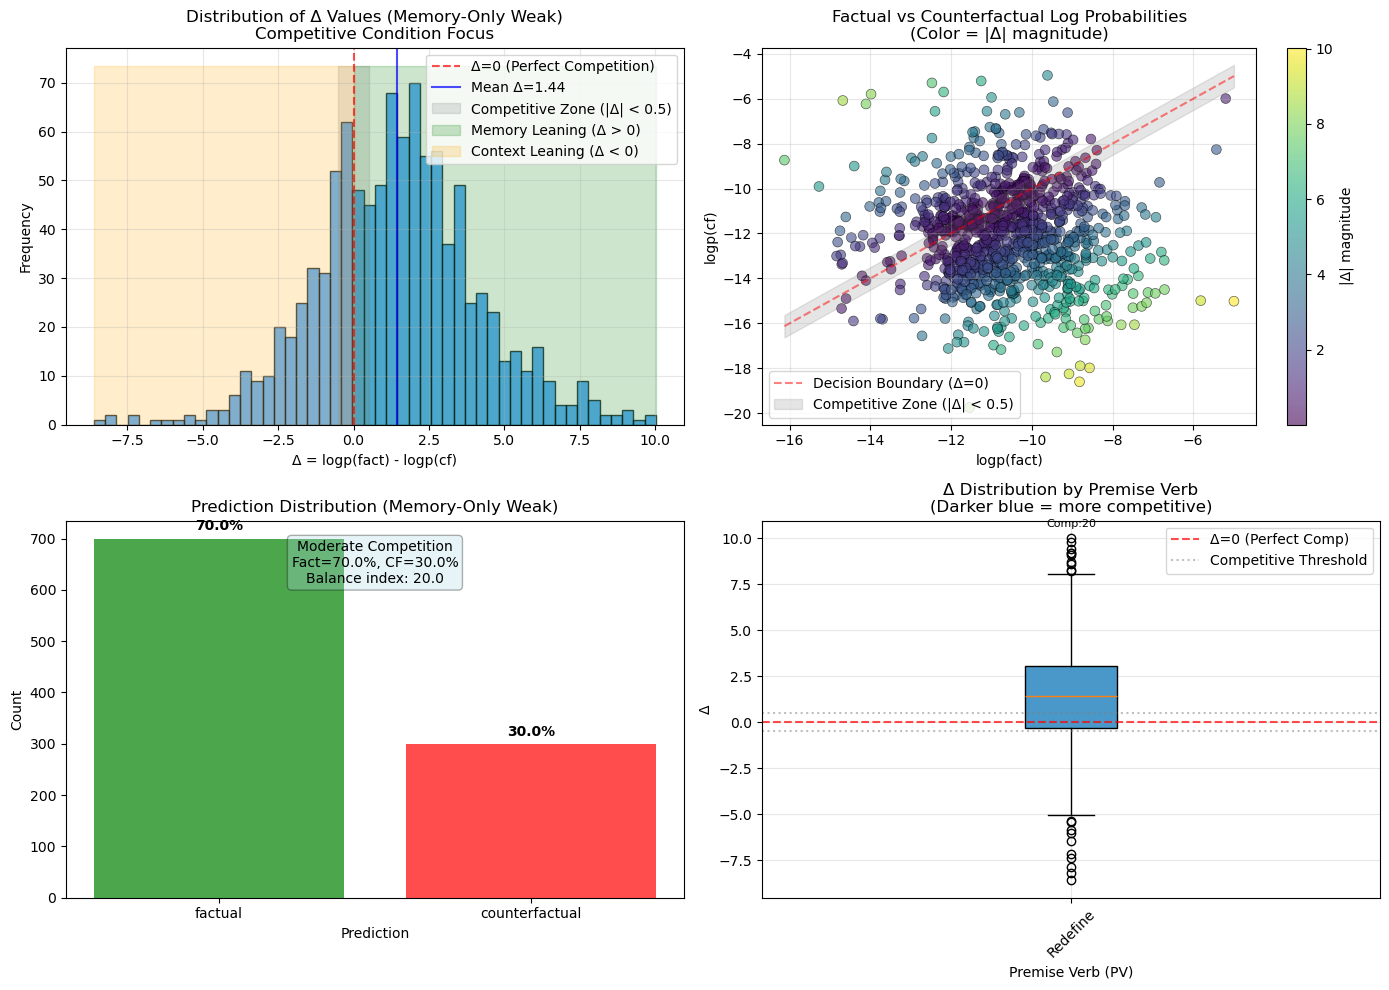

✓ Results saved to memory_only_weak_results.json

COMPARISON: WEAK vs STRONG MEMORY-ONLY INSTRUCTIONS

Metric                    Strong Memory-Only   Weak Memory-Only     Difference     
--------------------------------------------------------------------------------
% Factual                 73.0                 70.0                            -3.0
Avg Δ                     1.6274               1.4430                       -0.1844
% Following Memory        73.0                 70.0                            -3.0
Δ Std Dev                 N/A                  2.6749                           N/A
|Δ| Mean                  N/A                  2.3783                           N/A

Interpretation:
- Expected: Weak instructions → MORE competition, LESS clear preferences
- Expected: Weak instructions → LOWER factual %, LOWER Δ
- Expected: Weak instructions → HIGHER Δ std dev, LOWER |Δ| mean

Instruction Strength Effect:
  Weaker instructions reduce factual % by: -3.0%
  Weaker instructions

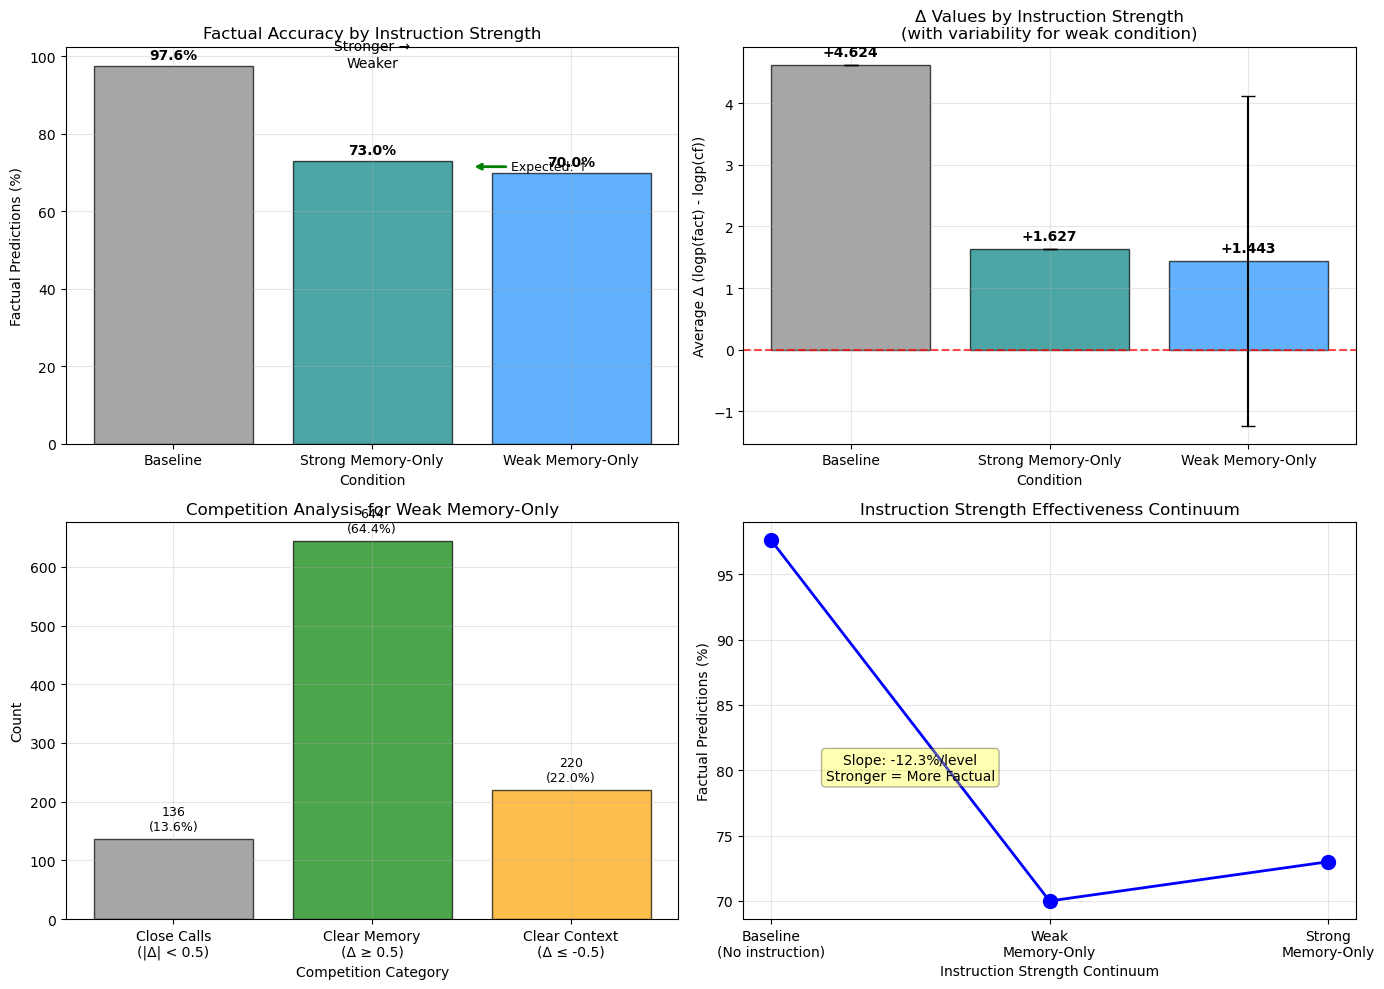


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prompt used:
    Answer using your own factual knowledge. Do NOT assume the text below is correct.
Text: "Airbus A380, a product created ...
  Prediction: factual
  logp(fact): -10.3876
  logp(cf): -14.8895
  Δ: 4.5018
  |Δ|: 4.5018
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrolet. What company produces the Honda Super Cub? Answer:'
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prompt used:
    Answer using your

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyWeakResult:
    """Stores results for a single prompt in Memory-Only Weak condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyWeakExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only Weak prompt template (Competitive/Weaker Instruction)
        self.memory_only_weak_template = (
            "Answer using your own factual knowledge. "
            "Do NOT assume the text below is correct.\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_memory_only_weak_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create memory-only weak prompt with competitive instructions"""
        return self.memory_only_weak_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyWeakResult]:
        """Process a single dataset item for Memory-Only Weak condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only weak prompt
            prompt = self.create_memory_only_weak_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyWeakResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Memory-Only Weak experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 6: MEMORY-ONLY WEAK (COMPETITIVE) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only Weak condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        # Calculate competition metrics
        # Weaker instructions may lead to more competition between memory and context
        delta_std = np.std([r.delta for r in self.results])
        delta_abs = np.mean([abs(r.delta) for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 6 RESULTS - MEMORY-ONLY WEAK (COMPETITIVE)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        print(f"\nCompetition Metrics:")
        print(f"  Δ std dev:  {delta_std:.4f} (higher = more variable behavior)")
        print(f"  |Δ| mean:   {delta_abs:.4f} (higher = stronger preferences)")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only Weak (Competitive) condition, we expect:")
        print("  - WEAKER instructions than Experiment 4 (Strong Memory-Only)")
        print("  - More competition between memory and context")
        print("  - Lower factual percentage than strong memory-only")
        print("  - More variable behavior (higher Δ std dev)")
        print("  - Lower |Δ| mean (weaker preferences)")
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        # Calculate balance index (how balanced the competition is)
        # Closer to 50% indicates more balanced competition
        balance_index = abs(positive_delta_percent - 50)
        
        print(f"\nPattern Analysis:")
        print(f"  Prompts with positive Δ (leaning memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        print(f"  Prompts with negative Δ (leaning context): {total - positive_delta_count}/{total} ({100 - positive_delta_percent:.1f}%)")
        print(f"  Balance index: {balance_index:.1f} (0 = perfectly balanced, 50 = completely imbalanced)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Δ Std':<10} {'Competition':<12}")
        print("-" * 80)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_memory_leaning = (verb_positive_delta / verb_total) * 100
                
                # Competition strength: how balanced (closer to 50% = more competitive)
                verb_competition = abs(verb_memory_leaning - 50)
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'memory_leaning_pct': verb_memory_leaning,
                    'competition_strength': verb_competition
                }
                
                # Competition indicator
                if verb_competition < 10:
                    competition_indicator = "High Comp"
                elif verb_competition < 25:
                    competition_indicator = "Med Comp"
                else:
                    competition_indicator = "Low Comp"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_delta_std:<10.4f} {competition_indicator:<12}")
        
        # Calculate overall competition metrics
        print(f"\n{'='*60}")
        print("COMPETITION ANALYSIS SUMMARY")
        print(f"{'='*60}")
        
        # Classify prompts by competition strength
        close_calls = sum(1 for r in self.results if abs(r.delta) < 0.5)
        clear_preferences = sum(1 for r in self.results if abs(r.delta) >= 0.5)
        
        print(f"\nDelta Magnitude Analysis:")
        print(f"  Close calls (|Δ| < 0.5): {close_calls}/{total} ({close_calls/total*100:.1f}%)")
        print(f"  Clear preferences (|Δ| ≥ 0.5): {clear_preferences}/{total} ({clear_preferences/total*100:.1f}%)")
        
        # Calculate bimodality score (how polarized the responses are)
        if delta_std > 0:
            bimodality = (avg_delta**2 + delta_std**2 - 1) / delta_std**2 if delta_std**2 > 0 else 0
        else:
            bimodality = 0
        
        print(f"\nBimodality Metrics:")
        print(f"  Δ standard deviation: {delta_std:.4f}")
        print(f"  Bimodality coefficient: {bimodality:.4f} (> 0.555 suggests bimodal distribution)")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only Weak experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values (competition focus)
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='dodgerblue', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Competition)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade regions for interpretation
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], -0.5, 0.5, alpha=0.2, color='gray', 
                               label='Competitive Zone (|Δ| < 0.5)')
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green', 
                               label='Memory Leaning (Δ > 0)')
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='orange', 
                               label='Context Leaning (Δ < 0)')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values (Memory-Only Weak)\nCompetitive Condition Focus')
        axes[0, 0].legend(loc='upper right')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot with competition zones
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by Δ magnitude (competition strength)
        delta_magnitudes = [abs(r.delta) for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=delta_magnitudes, cmap='viridis', alpha=0.6, 
                                     edgecolors='black', linewidth=0.5, s=50)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        # Add competitive zone (close to diagonal)
        diag_range = np.linspace(min(factual_logps), max(factual_logps), 100)
        axes[0, 1].fill_between(diag_range, diag_range - 0.5, diag_range + 0.5, 
                               alpha=0.2, color='gray', label='Competitive Zone (|Δ| < 0.5)')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities\n(Color = |Δ| magnitude)')
        axes[0, 1].legend(loc='best')
        axes[0, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, 1], label='|Δ| magnitude')
        
        # Plot 3: Prediction distribution with competition annotation
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution (Memory-Only Weak)')
        
        # Add percentage labels
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Add competition annotation
        balance = abs(factual_pct - 50)
        competition_level = "High Competition" if balance < 15 else "Moderate Competition" if balance < 30 else "Low Competition"
        
        comp_text = f"{competition_level}\nFact={factual_pct:.1f}%, CF={cf_pct:.1f}%\nBalance index: {balance:.1f}"
        axes[1, 0].text(0.5, 0.95, comp_text, transform=axes[1, 0].transAxes,
                       ha='center', va='top', fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
        
        # Plot 4: Δ distribution by premise verb with competition indicators
        premise_deltas = {}
        premise_competition = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate competition strength
                verb_positive = sum(1 for d in verb_deltas if d > 0)
                verb_competition = abs((verb_positive / len(verb_deltas) * 100) - 50)
                premise_competition[verb] = verb_competition
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on competition strength
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                competition = premise_competition.get(verb, 0)
                # More competitive = darker blue, less competitive = lighter blue
                color_intensity = max(0.3, 1 - competition/50)  # Normalize to 0-1
                patch.set_facecolor(plt.cm.Blues(color_intensity))
                
                # Add competition percentage as text
                axes[1, 1].text(positions[i], np.max(list(premise_deltas.values())[i]) * 1.05,
                               f'Comp:{competition:.0f}', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Comp)')
            axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Competitive Threshold')
            axes[1, 1].axhline(y=-0.5, color='gray', linestyle=':', alpha=0.5)
            
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Darker blue = more competitive)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend(loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'memory_only_weak_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_strong_memory_only(self, strong_memory_path: str = "memory_only_results.json"):
        """Compare Weak Memory-Only with Strong Memory-Only (Experiment 4)"""
        try:
            with open(strong_memory_path, 'r') as f:
                strong_data = json.load(f)
            
            strong_summary = strong_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100
            
            # Calculate competition metrics for weak condition
            delta_std = np.std([r.delta for r in self.results])
            delta_abs = np.mean([abs(r.delta) for r in self.results])
            
            print(f"\n{'='*70}")
            print("COMPARISON: WEAK vs STRONG MEMORY-ONLY INSTRUCTIONS")
            print(f"{'='*70}")
            print(f"\n{'Metric':<25} {'Strong Memory-Only':<20} {'Weak Memory-Only':<20} {'Difference':<15}")
            print("-" * 80)
            
            print(f"{'% Factual':<25} "
                  f"{strong_summary['factual_percent']:<20.1f} "
                  f"{factual_percent:<20.1f} "
                  f"{factual_percent - strong_summary['factual_percent']:>+15.1f}")
            
            print(f"{'Avg Δ':<25} "
                  f"{strong_summary['avg_delta']:<20.4f} "
                  f"{avg_delta:<20.4f} "
                  f"{avg_delta - strong_summary['avg_delta']:>+15.4f}")
            
            print(f"{'% Following Memory':<25} "
                  f"{strong_summary.get('positive_delta_percent', 0):<20.1f} "
                  f"{positive_delta_percent:<20.1f} "
                  f"{positive_delta_percent - strong_summary.get('positive_delta_percent', 0):>+15.1f}")
            
            print(f"{'Δ Std Dev':<25} "
                  f"{'N/A':<20} "
                  f"{delta_std:<20.4f} "
                  f"{'N/A':>15}")
            
            print(f"{'|Δ| Mean':<25} "
                  f"{'N/A':<20} "
                  f"{delta_abs:<20.4f} "
                  f"{'N/A':>15}")
            
            print(f"\nInterpretation:")
            print(f"- Expected: Weak instructions → MORE competition, LESS clear preferences")
            print(f"- Expected: Weak instructions → LOWER factual %, LOWER Δ")
            print(f"- Expected: Weak instructions → HIGHER Δ std dev, LOWER |Δ| mean")
            
            # Calculate instruction strength effect
            factual_diff = factual_percent - strong_summary['factual_percent']
            delta_diff = avg_delta - strong_summary['avg_delta']
            
            print(f"\nInstruction Strength Effect:")
            print(f"  Weaker instructions reduce factual % by: {factual_diff:+.1f}%")
            print(f"  Weaker instructions reduce Δ by: {delta_diff:+.4f}")
            
            # Classify based on results
            if factual_diff < 0 and delta_diff < 0:
                print(f"\nConclusion: WEAKER instructions lead to:")
                print(f"  ✓ More competitive behavior")
                print(f"  ✓ Less parametric memory dominance")
                print(f"  ✓ Instructions successfully weakened")
            else:
                print(f"\nConclusion: Unexpected results - weak instructions may not be weaker enough")
            
        except FileNotFoundError:
            print(f"✗ Strong Memory-Only results file not found at {strong_memory_path}")
            print("  Run Experiment 4 first to enable comparison")
    
    def compare_with_baseline(self, baseline_path: str = "baseline_results.json"):
        """Compare Weak Memory-Only with Baseline"""
        try:
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            
            baseline_summary = baseline_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            print(f"\n{'='*60}")
            print("COMPARISON: WEAK MEMORY-ONLY vs BASELINE")
            print(f"{'='*60}")
            print(f"\n{'Metric':<25} {'Baseline':<15} {'Weak Memory-Only':<15} {'Difference':<15}")
            print("-" * 70)
            
            print(f"{'% Factual':<25} "
                  f"{baseline_summary['factual_percent']:<15.1f} "
                  f"{factual_percent:<15.1f} "
                  f"{factual_percent - baseline_summary['factual_percent']:>+15.1f}")
            
            print(f"{'Avg Δ':<25} "
                  f"{baseline_summary['avg_delta']:<15.4f} "
                  f"{avg_delta:<15.4f} "
                  f"{avg_delta - baseline_summary['avg_delta']:>+15.4f}")
            
            print(f"\nInterpretation:")
            print(f"- Baseline: No specific instructions (mixed behavior)")
            print(f"- Weak Memory-Only: Weak instructions to use memory")
            print(f"- Expected: Weak instructions should INCREASE factual % vs Baseline")
            print(f"- Expected: Weak instructions should INCREASE Δ vs Baseline")
            
            factual_diff = factual_percent - baseline_summary['factual_percent']
            delta_diff = avg_delta - baseline_summary['avg_delta']
            
            print(f"\nInstruction Effectiveness:")
            print(f"  Factual % change: {factual_diff:+.1f}% (expected positive)")
            print(f"  Δ change: {delta_diff:+.4f} (expected positive)")
            
            if factual_diff > 0 and delta_diff > 0:
                print(f"  Conclusion: ✓ Weak instructions are EFFECTIVE")
            elif factual_diff > 0 or delta_diff > 0:
                print(f"  Conclusion: ⚠ Weak instructions are PARTIALLY effective")
            else:
                print(f"  Conclusion: ✗ Weak instructions are INEFFECTIVE")
            
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
    
    def compare_all_memory_conditions(self, 
                                     strong_memory_path: str = "memory_only_results.json",
                                     memory_pv_path: str = "memory_only_pv_results.json"):
        """Compare all memory conditions: Weak, Strong, and Strong+PV"""
        comparisons = []
        
        try:
            # Load strong memory-only results
            with open(strong_memory_path, 'r') as f:
                strong_data = json.load(f)
            strong_summary = strong_data['summary']
            comparisons.append(('Strong Memory-Only', strong_summary))
        except FileNotFoundError:
            print(f"✗ Strong Memory-Only results file not found at {strong_memory_path}")
        
        try:
            # Load memory-only PV results
            with open(memory_pv_path, 'r') as f:
                memory_pv_data = json.load(f)
            memory_pv_summary = memory_pv_data['summary']
            comparisons.append(('Strong Memory-Only+PV', memory_pv_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only PV results file not found at {memory_pv_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        avg_delta = np.mean([r.delta for r in self.results])
        positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100
        
        print(f"\n{'='*80}")
        print("COMPARISON ACROSS ALL MEMORY CONDITIONS")
        print(f"{'='*80}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<20}", end="")
        print(f"{'Weak Memory-Only':<20}")
        print("-" * (25 + 20 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<20.1f}", end="")
        print(f"{factual_percent:<20.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<20.4f}", end="")
        print(f"{avg_delta:<20.4f}")
        
        # % Following memory instructions
        print(f"{'% Following Memory':<25} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Strong Memory-Only':
                mem_percent = summary.get('positive_delta_percent', 0)
            elif exp_name == 'Strong Memory-Only+PV':
                mem_percent = summary.get('positive_delta_percent', 0)
            else:
                mem_percent = 0
            print(f"{mem_percent:<20.1f}", end="")
        print(f"{positive_delta_percent:<20.1f}")
        
        print(f"\nInterpretation:")
        print(f"Instruction Strength Continuum:")
        print(f"  Weak Memory-Only → Strong Memory-Only → Strong Memory-Only+PV")
        print(f"Expected: Increasing factual %, increasing Δ, increasing instruction following")
        
        # Calculate continuum effects
        print(f"\n{'='*60}")
        print("INSTRUCTION STRENGTH CONTINUUM ANALYSIS")
        print(f"{'='*60}")
        
        if 'Strong Memory-Only' in [name for name, _ in comparisons]:
            strong_idx = [name for name, _ in comparisons].index('Strong Memory-Only')
            strong_factual = comparisons[strong_idx][1].get('factual_percent', 0)
            strong_delta = comparisons[strong_idx][1].get('avg_delta', 0)
            
            weak_vs_strong_factual = factual_percent - strong_factual
            weak_vs_strong_delta = avg_delta - strong_delta
            
            print(f"\nWeak vs Strong Memory-Only:")
            print(f"  Factual % difference: {weak_vs_strong_factual:+.1f}% (expected negative)")
            print(f"  Δ difference: {weak_vs_strong_delta:+.4f} (expected negative)")
            print(f"  Interpretation: {'✓ Weaker as expected' if weak_vs_strong_factual < 0 else '⚠ Not weaker as expected'}")
        
        # Calculate effectiveness relative to baseline
        try:
            with open("baseline_results.json", 'r') as f:
                baseline_summary = json.load(f)['summary']
            
            baseline_factual = baseline_summary['factual_percent']
            baseline_delta = baseline_summary['avg_delta']
            
            print(f"\nAll conditions vs Baseline:")
            print(f"  Baseline factual %: {baseline_factual:.1f}%")
            print(f"  Baseline Δ: {baseline_delta:.4f}")
            
            conditions = [('Weak Memory-Only', factual_percent, avg_delta)]
            for exp_name, summary in comparisons:
                conditions.append((exp_name, summary.get('factual_percent', 0), summary.get('avg_delta', 0)))
            
            print(f"\n{'Condition':<25} {'Δ Factual vs Baseline':<25} {'Δ Δ vs Baseline':<20}")
            print("-" * 70)
            for name, fact, delta in conditions:
                fact_diff = fact - baseline_factual
                delta_diff = delta - baseline_delta
                print(f"{name:<25} {fact_diff:>+24.1f}% {delta_diff:>+19.4f}")
            
        except FileNotFoundError:
            print(f"\nNote: Baseline comparison unavailable")
    
    def create_competition_analysis_plot(self, 
                                        baseline_path: str = "baseline_results.json",
                                        strong_memory_path: str = "memory_only_results.json"):
        """Create specialized plot for competition analysis"""
        try:
            # Load comparison data
            with open(baseline_path, 'r') as f:
                baseline_summary = json.load(f)['summary']
            
            with open(strong_memory_path, 'r') as f:
                strong_summary = json.load(f)['summary']
            
            # Our data
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            delta_std = np.std([r.delta for r in self.results])
            
            # Create figure
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Plot 1: Factual percentage comparison
            conditions = ['Baseline', 'Strong Memory-Only', 'Weak Memory-Only']
            factuals = [baseline_summary['factual_percent'], 
                       strong_summary['factual_percent'], 
                       factual_percent]
            colors = ['gray', 'teal', 'dodgerblue']
            
            bars1 = axes[0, 0].bar(conditions, factuals, color=colors, alpha=0.7, edgecolor='black')
            axes[0, 0].set_xlabel('Condition')
            axes[0, 0].set_ylabel('Factual Predictions (%)')
            axes[0, 0].set_title('Factual Accuracy by Instruction Strength')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, fact in zip(bars1, factuals):
                height = bar.get_height()
                axes[0, 0].text(bar.get_x() + bar.get_width()/2, height + 1, 
                               f'{fact:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            # Add expected arrows
            axes[0, 0].annotate('Expected: ↑', xy=(1.5, (factuals[1] + factuals[2])/2),
                               xytext=(1.7, (factuals[1] + factuals[2])/2),
                               arrowprops=dict(arrowstyle='->', color='green', lw=2),
                               ha='left', va='center', fontsize=9)
            axes[0, 0].annotate('Stronger →\nWeaker', xy=(0.5, 0.95), 
                               xycoords='axes fraction', ha='center', fontsize=10)
            
            # Plot 2: Δ comparison with variability
            deltas = [baseline_summary['avg_delta'], 
                     strong_summary['avg_delta'], 
                     avg_delta]
            
            # We only have std for weak condition
            delta_stds = [0, 0, delta_std]  # Placeholder for others
            
            x_pos = np.arange(len(conditions))
            bars2 = axes[0, 1].bar(x_pos, deltas, color=colors, alpha=0.7, edgecolor='black', yerr=delta_stds, capsize=5)
            axes[0, 1].set_xlabel('Condition')
            axes[0, 1].set_ylabel('Average Δ (logp(fact) - logp(cf))')
            axes[0, 1].set_title('Δ Values by Instruction Strength\n(with variability for weak condition)')
            axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            axes[0, 1].set_xticks(x_pos)
            axes[0, 1].set_xticklabels(conditions)
            axes[0, 1].grid(True, alpha=0.3)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                axes[0, 1].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.15), 
                               f'{delta:+.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                               fontweight='bold')
            
            # Plot 3: Competition metrics for weak condition
            # Calculate competition metrics
            close_calls = sum(1 for r in self.results if abs(r.delta) < 0.5)
            clear_memory = sum(1 for r in self.results if r.delta >= 0.5)
            clear_context = sum(1 for r in self.results if r.delta <= -0.5)
            
            competition_labels = ['Close Calls\n(|Δ| < 0.5)', 'Clear Memory\n(Δ ≥ 0.5)', 'Clear Context\n(Δ ≤ -0.5)']
            competition_values = [close_calls, clear_memory, clear_context]
            competition_percentages = [v/total*100 for v in competition_values]
            comp_colors = ['gray', 'green', 'orange']
            
            axes[1, 0].bar(competition_labels, competition_values, color=comp_colors, alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Competition Category')
            axes[1, 0].set_ylabel('Count')
            axes[1, 0].set_title('Competition Analysis for Weak Memory-Only')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Add value and percentage labels
            for i, (val, pct) in enumerate(zip(competition_values, competition_percentages)):
                axes[1, 0].text(i, val + total*0.01, f'{val}\n({pct:.1f}%)', 
                               ha='center', va='bottom', fontsize=9)
            
            # Plot 4: Instruction effectiveness continuum
            instruction_strength = [1, 2, 3]  # Baseline, Weak, Strong
            factual_by_strength = [baseline_summary['factual_percent'], factual_percent, strong_summary['factual_percent']]
            
            axes[1, 1].plot(instruction_strength, factual_by_strength, 'bo-', linewidth=2, markersize=10)
            axes[1, 1].set_xlabel('Instruction Strength Continuum')
            axes[1, 1].set_ylabel('Factual Predictions (%)')
            axes[1, 1].set_title('Instruction Strength Effectiveness Continuum')
            axes[1, 1].set_xticks(instruction_strength)
            axes[1, 1].set_xticklabels(['Baseline\n(No instruction)', 'Weak\nMemory-Only', 'Strong\nMemory-Only'])
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add trend line annotation
            slope = (factual_by_strength[-1] - factual_by_strength[0]) / (instruction_strength[-1] - instruction_strength[0])
            axes[1, 1].text(1.5, np.mean(factual_by_strength), 
                           f'Slope: {slope:.1f}%/level\nStronger = More Factual', 
                           ha='center', va='center', fontsize=10,
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
            
            plt.tight_layout()
            plt.savefig(f'competition_analysis_{self.model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except FileNotFoundError as e:
            print(f"✗ Could not create competition analysis plot: {e}")
    
    def save_results(self, output_path: str = "memory_only_weak_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_memory_leaning = (verb_positive_delta / verb_total) * 100
                verb_competition = abs(verb_memory_leaning - 50)
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'memory_leaning_percent': verb_memory_leaning,
                    'competition_strength': verb_competition,
                    'competition_level': 'High' if verb_competition < 10 else 'Medium' if verb_competition < 25 else 'Low'
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        # Competition metrics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs_mean = np.mean([abs(r.delta) for r in self.results])
        close_calls = sum(1 for r in self.results if abs(r.delta) < 0.5)
        close_calls_percent = (close_calls / total) * 100
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Memory-Only Weak (Competitive)',
                'prompt_template': self.memory_only_weak_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'positive_delta_percent': positive_delta_percent,
                    'competition_metrics': {
                        'delta_std': delta_std,
                        'delta_abs_mean': delta_abs_mean,
                        'close_calls_count': close_calls,
                        'close_calls_percent': close_calls_percent,
                        'balance_index': abs(positive_delta_percent - 50)
                    }
                },
                'premise_verb_summary': verb_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 6
    experiment = MemoryOnlyWeakExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with Strong Memory-Only
    experiment.compare_with_strong_memory_only("memory_only_results.json")
    
    # Compare with Baseline
    experiment.compare_with_baseline("baseline_results.json")
    
    # Compare all memory conditions
    experiment.compare_all_memory_conditions("memory_only_results.json", "memory_only_pv_results.json")
    
    # Create competition analysis plot
    experiment.create_competition_analysis_plot("baseline_results.json", "memory_only_results.json")
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            # Show first 120 characters of prompt
            prompt_preview = result.prompt[:120] + "..." if len(result.prompt) > 120 else result.prompt
            print(f"    {prompt_preview}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print(f"  |Δ|: {abs(result.delta):.4f}")
            print("-" * 90)


EXPERIMENT 7: BOTH ALLOWED (NATURAL COMPETITION) - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [00:37<00:00, 26.89it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 7 RESULTS - BOTH ALLOWED (NATURAL COMPETITION)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 731 (73.1%)
  Counterfactual predictions: 269 (26.9%)

Average Log Probabilities:
  logp(fact): -10.9736
  logp(cf):   -12.8114
  Δ:          1.8377 (logp(fact) - logp(cf))

Natural Competition Metrics:
  Δ std dev:  2.9950 (higher = more variable behavior)
  |Δ| mean:   2.7157 (higher = stronger preferences)

THEORETICAL FRAMEWORK ANALYSIS

In Both Allowed condition (Natural Competition), we expect:
  - No explicit instructions bias the model
  - Model naturally balances parametric memory vs in-context learning
  - This represents the 'default' or 'natural' competition state
  - Useful as baseline for comparing instruction effectiveness

Natural Dominance Analysis:
  Memory (parametric) dominance: 73.1%
  Context (ICL) dominance: 26.9%
  Net dominance: +46.2% (positive = memory dominant)

Balance Analysis:
  Balance in

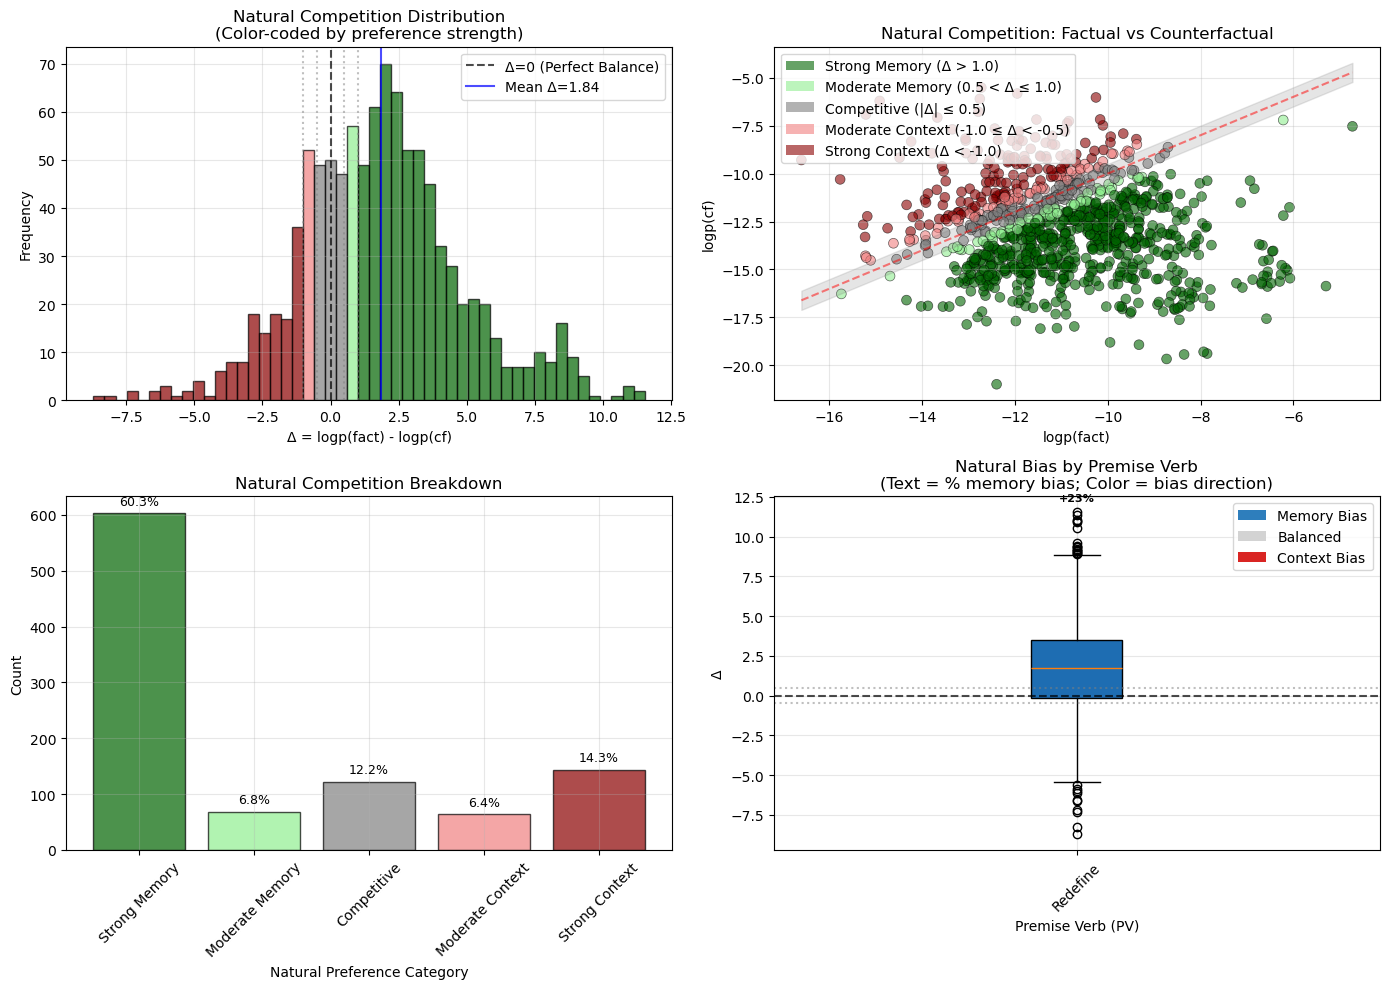


COMPARISON: BOTH ALLOWED vs BASELINE (CLEAN QUESTION)

Metric                    Baseline (Q only)    Both Allowed (CF + Q) Difference     
--------------------------------------------------------------------------------
% Factual                 97.6                 73.1                           -24.5
Avg Δ                     4.6241               1.8377                       -2.7863

Interpretation:
- Baseline: Clean question only (no counterfactual context)
- Both Allowed: Question + counterfactual context (natural competition)
- Difference shows effect of adding counterfactual context
- Expected: Adding CF should DECREASE factual % and DECREASE Δ

Effect of Adding Counterfactual Context:
  Factual % change: -24.5% (expected negative)
  Δ change: -2.7863 (expected negative)
  Conclusion: ✓ Counterfactual context biases toward ICL as expected

COMPARISON: NATURAL COMPETITION vs INSTRUCTION-BASED CONDITIONS

Metric                    Context-Only        Memory-Only         Memory-On

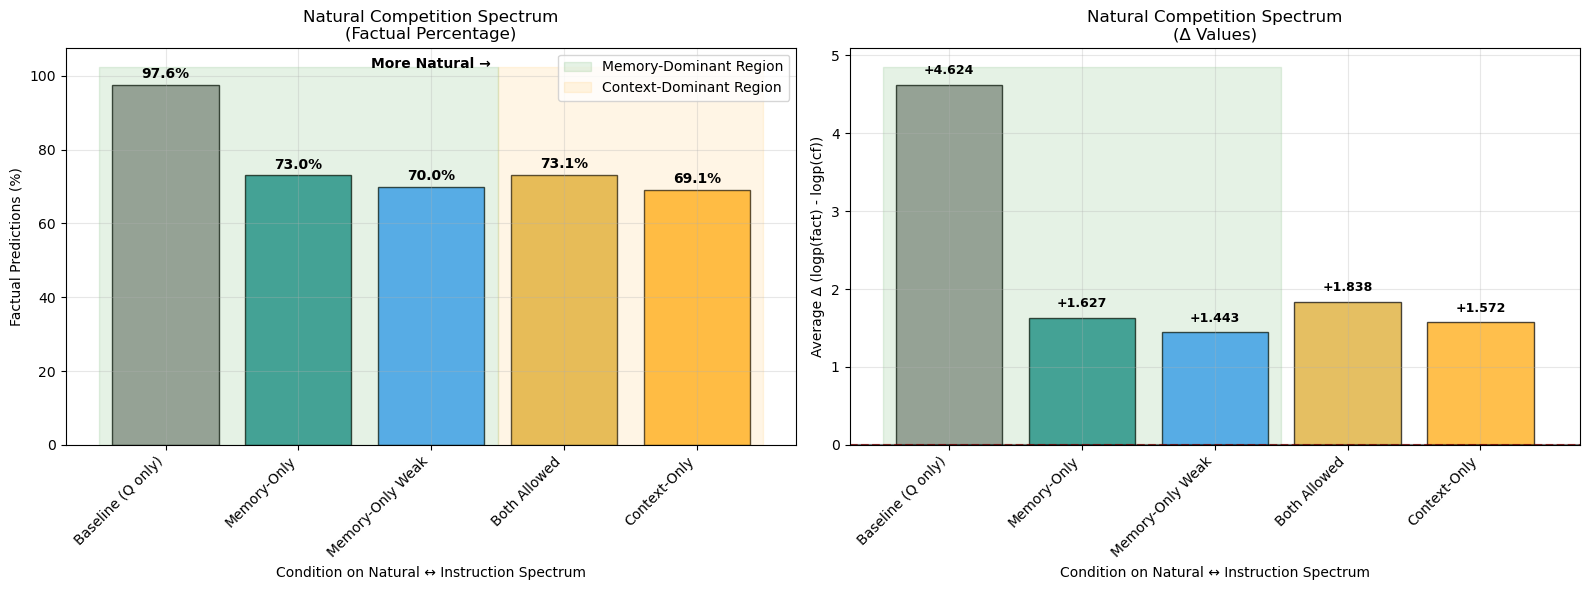

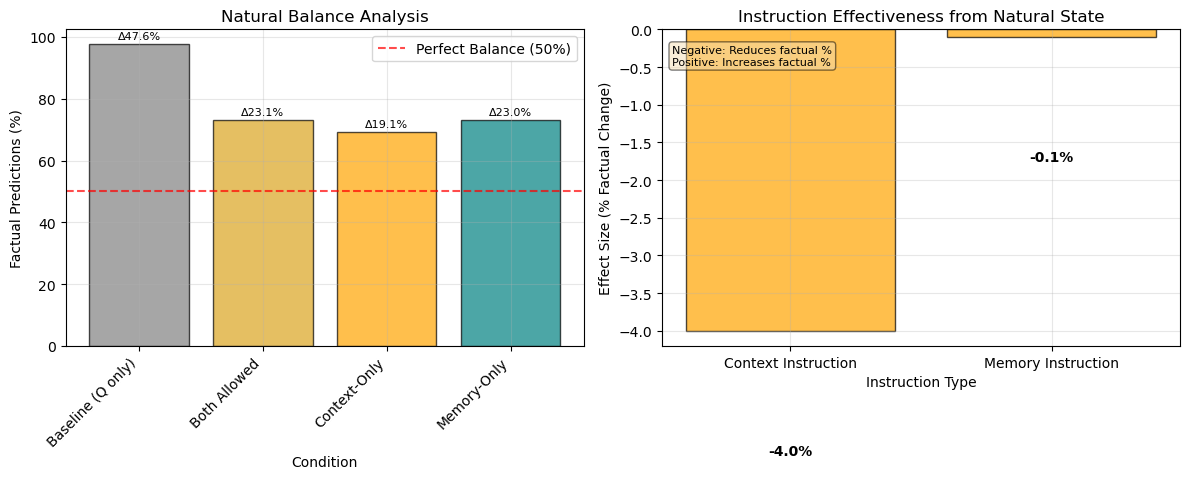


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prompt used:
    Text: "Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:"

Question: Who...
  Prediction: factual
  logp(fact): -11.0353
  logp(cf): -16.2165
  Δ: 5.1813
  Natural Competition Category: Strong Memory
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrolet. What company produces the Honda Super Cub? Answer:'
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prompt used:
    Text:

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class BothAllowedResult:
    """Stores results for a single prompt in Both Allowed condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class BothAllowedExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Both Allowed prompt template (Natural Competition)
        self.both_allowed_template = (
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                premise_verb = item['prompt'].split(':')[0].strip()
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
            
            print("\nDataset Distribution:")
            print("-" * 40)
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_both_allowed_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create both allowed prompt for natural competition"""
        return self.both_allowed_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[BothAllowedResult]:
        """Process a single dataset item for Both Allowed condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create both allowed prompt
            prompt = self.create_both_allowed_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = BothAllowedResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Both Allowed experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 7: BOTH ALLOWED (NATURAL COMPETITION) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Both Allowed condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        # Calculate natural competition metrics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs = np.mean([abs(r.delta) for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 7 RESULTS - BOTH ALLOWED (NATURAL COMPETITION)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        print(f"\nNatural Competition Metrics:")
        print(f"  Δ std dev:  {delta_std:.4f} (higher = more variable behavior)")
        print(f"  |Δ| mean:   {delta_abs:.4f} (higher = stronger preferences)")
        
        # Theoretical framework analysis
        print(f"\n{'='*60}")
        print("THEORETICAL FRAMEWORK ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Both Allowed condition (Natural Competition), we expect:")
        print("  - No explicit instructions bias the model")
        print("  - Model naturally balances parametric memory vs in-context learning")
        print("  - This represents the 'default' or 'natural' competition state")
        print("  - Useful as baseline for comparing instruction effectiveness")
        
        # Calculate dominance metrics
        memory_dominance = factual_percent  # % factual = memory dominance
        context_dominance = counterfactual_percent  # % counterfactual = context dominance
        net_dominance = memory_dominance - context_dominance
        
        print(f"\nNatural Dominance Analysis:")
        print(f"  Memory (parametric) dominance: {memory_dominance:.1f}%")
        print(f"  Context (ICL) dominance: {context_dominance:.1f}%")
        print(f"  Net dominance: {net_dominance:+.1f}% (positive = memory dominant)")
        
        # Balance analysis
        balance_index = abs(factual_percent - 50)
        
        print(f"\nBalance Analysis:")
        print(f"  Balance index: {balance_index:.1f} (0 = perfect balance, 50 = completely imbalanced)")
        if balance_index < 10:
            print(f"  Interpretation: HIGHLY BALANCED natural competition")
        elif balance_index < 25:
            print(f"  Interpretation: MODERATELY BALANCED natural competition")
        else:
            print(f"  Interpretation: IMBALANCED natural competition")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Δ Std':<10} {'Natural Bias':<12}")
        print("-" * 80)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_net_dominance = verb_factual_pct - (100 - verb_factual_pct)
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'net_dominance': verb_net_dominance
                }
                
                # Natural bias indicator
                if verb_net_dominance > 10:
                    bias_indicator = "Memory Bias"
                elif verb_net_dominance < -10:
                    bias_indicator = "Context Bias"
                else:
                    bias_indicator = "Balanced"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_delta_std:<10.4f} {bias_indicator:<12}")
        
        # Calculate overall natural competition classification
        print(f"\n{'='*60}")
        print("NATURAL COMPETITION CLASSIFICATION")
        print(f"{'='*60}")
        
        # Classify prompts by natural preference strength
        strong_memory = sum(1 for r in self.results if r.delta > 1.0)
        moderate_memory = sum(1 for r in self.results if 0.5 < r.delta <= 1.0)
        competitive = sum(1 for r in self.results if -0.5 <= r.delta <= 0.5)
        moderate_context = sum(1 for r in self.results if -1.0 <= r.delta < -0.5)
        strong_context = sum(1 for r in self.results if r.delta < -1.0)
        
        print(f"\nNatural Preference Spectrum:")
        print(f"  Strong Memory (Δ > 1.0): {strong_memory}/{total} ({strong_memory/total*100:.1f}%)")
        print(f"  Moderate Memory (0.5 < Δ ≤ 1.0): {moderate_memory}/{total} ({moderate_memory/total*100:.1f}%)")
        print(f"  Competitive (|Δ| ≤ 0.5): {competitive}/{total} ({competitive/total*100:.1f}%)")
        print(f"  Moderate Context (-1.0 ≤ Δ < -0.5): {moderate_context}/{total} ({moderate_context/total*100:.1f}%)")
        print(f"  Strong Context (Δ < -1.0): {strong_context}/{total} ({strong_context/total*100:.1f}%)")
        
        # Calculate natural bias summary
        memory_total = strong_memory + moderate_memory
        context_total = moderate_context + strong_context
        
        print(f"\nSummary Classification:")
        print(f"  Memory-leaning total: {memory_total}/{total} ({memory_total/total*100:.1f}%)")
        print(f"  Competitive: {competitive}/{total} ({competitive/total*100:.1f}%)")
        print(f"  Context-leaning total: {context_total}/{total} ({context_total/total*100:.1f}%)")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Both Allowed experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution of Δ values (natural competition)
        deltas = [r.delta for r in self.results]
        
        # Create histogram with natural competition zones
        n, bins, patches = axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='goldenrod', edgecolor='black')
        
        # Color patches based on zones
        for i in range(len(patches)):
            bin_center = (bins[i] + bins[i+1]) / 2
            if bin_center > 1.0:
                patches[i].set_facecolor('darkgreen')  # Strong memory
            elif bin_center > 0.5:
                patches[i].set_facecolor('lightgreen')  # Moderate memory
            elif bin_center > -0.5:
                patches[i].set_facecolor('gray')  # Competitive
            elif bin_center > -1.0:
                patches[i].set_facecolor('lightcoral')  # Moderate context
            else:
                patches[i].set_facecolor('darkred')  # Strong context
        
        axes[0, 0].axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Balance)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Add zone labels
        axes[0, 0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=-0.5, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=1.0, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=-1.0, color='gray', linestyle=':', alpha=0.5)
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Natural Competition Distribution\n(Color-coded by preference strength)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot with natural competition coloring
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by Δ category
        colors = []
        for r in self.results:
            if r.delta > 1.0:
                colors.append('darkgreen')  # Strong memory
            elif r.delta > 0.5:
                colors.append('lightgreen')  # Moderate memory
            elif r.delta > -0.5:
                colors.append('gray')  # Competitive
            elif r.delta > -1.0:
                colors.append('lightcoral')  # Moderate context
            else:
                colors.append('darkred')  # Strong context
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=colors, alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Δ=0 (Balance Line)')
        
        # Add competitive zone (close to diagonal)
        diag_range = np.linspace(min(factual_logps), max(factual_logps), 100)
        axes[0, 1].fill_between(diag_range, diag_range - 0.5, diag_range + 0.5, 
                               alpha=0.2, color='gray', label='Competitive Zone (|Δ| < 0.5)')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Natural Competition: Factual vs Counterfactual')
        axes[0, 1].legend(loc='best')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add custom legend for point colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkgreen', alpha=0.6, label='Strong Memory (Δ > 1.0)'),
            Patch(facecolor='lightgreen', alpha=0.6, label='Moderate Memory (0.5 < Δ ≤ 1.0)'),
            Patch(facecolor='gray', alpha=0.6, label='Competitive (|Δ| ≤ 0.5)'),
            Patch(facecolor='lightcoral', alpha=0.6, label='Moderate Context (-1.0 ≤ Δ < -0.5)'),
            Patch(facecolor='darkred', alpha=0.6, label='Strong Context (Δ < -1.0)')
        ]
        axes[0, 1].legend(handles=legend_elements, loc='upper left')
        
        # Plot 3: Natural dominance breakdown
        categories = ['Strong Memory', 'Moderate Memory', 'Competitive', 'Moderate Context', 'Strong Context']
        counts = [
            sum(1 for r in self.results if r.delta > 1.0),
            sum(1 for r in self.results if 0.5 < r.delta <= 1.0),
            sum(1 for r in self.results if -0.5 <= r.delta <= 0.5),
            sum(1 for r in self.results if -1.0 <= r.delta < -0.5),
            sum(1 for r in self.results if r.delta < -1.0)
        ]
        colors = ['darkgreen', 'lightgreen', 'gray', 'lightcoral', 'darkred']
        
        bars = axes[1, 0].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Natural Preference Category')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Natural Competition Breakdown')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_xticklabels(categories, rotation=45)
        
        # Add percentage labels
        total = len(self.results)
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / total) * 100
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + total*0.01, 
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Δ distribution by premise verb with natural bias
        premise_deltas = {}
        premise_bias = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate natural bias
                verb_factual = sum(1 for r in verb_results if r.delta > 0)
                verb_bias = (verb_factual / len(verb_deltas) * 100) - 50  # Positive = memory bias
                premise_bias[verb] = verb_bias
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on natural bias
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                bias = premise_bias.get(verb, 0)
                # Color scale: blue for memory bias, red for context bias, white for balanced
                if bias > 5:
                    # Memory bias
                    color_intensity = min(0.8, bias/50)
                    patch.set_facecolor(plt.cm.Blues(0.3 + color_intensity))
                elif bias < -5:
                    # Context bias
                    color_intensity = min(0.8, abs(bias)/50)
                    patch.set_facecolor(plt.cm.Reds(0.3 + color_intensity))
                else:
                    # Balanced
                    patch.set_facecolor('lightgray')
                
                # Add bias value as text
                axes[1, 1].text(positions[i], np.max(list(premise_deltas.values())[i]) * 1.05,
                               f'{bias:+.0f}%', ha='center', va='bottom', fontsize=8,
                               fontweight='bold' if abs(bias) > 10 else 'normal')
            
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
            axes[1, 1].axhline(y=-0.5, color='gray', linestyle=':', alpha=0.5)
            
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Natural Bias by Premise Verb\n(Text = % memory bias; Color = bias direction)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add bias direction legend
            bias_legend = [
                Patch(facecolor=plt.cm.Blues(0.7), label='Memory Bias'),
                Patch(facecolor='lightgray', label='Balanced'),
                Patch(facecolor=plt.cm.Reds(0.7), label='Context Bias')
            ]
            axes[1, 1].legend(handles=bias_legend, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'both_allowed_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_baseline(self, baseline_path: str = "baseline_results.json"):
        """Compare Both Allowed with Baseline (clean question only)"""
        try:
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            
            baseline_summary = baseline_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            print(f"\n{'='*70}")
            print("COMPARISON: BOTH ALLOWED vs BASELINE (CLEAN QUESTION)")
            print(f"{'='*70}")
            print(f"\n{'Metric':<25} {'Baseline (Q only)':<20} {'Both Allowed (CF + Q)':<20} {'Difference':<15}")
            print("-" * 80)
            
            print(f"{'% Factual':<25} "
                  f"{baseline_summary['factual_percent']:<20.1f} "
                  f"{factual_percent:<20.1f} "
                  f"{factual_percent - baseline_summary['factual_percent']:>+15.1f}")
            
            print(f"{'Avg Δ':<25} "
                  f"{baseline_summary['avg_delta']:<20.4f} "
                  f"{avg_delta:<20.4f} "
                  f"{avg_delta - baseline_summary['avg_delta']:>+15.4f}")
            
            print(f"\nInterpretation:")
            print(f"- Baseline: Clean question only (no counterfactual context)")
            print(f"- Both Allowed: Question + counterfactual context (natural competition)")
            print(f"- Difference shows effect of adding counterfactual context")
            print(f"- Expected: Adding CF should DECREASE factual % and DECREASE Δ")
            
            factual_diff = factual_percent - baseline_summary['factual_percent']
            delta_diff = avg_delta - baseline_summary['avg_delta']
            
            print(f"\nEffect of Adding Counterfactual Context:")
            print(f"  Factual % change: {factual_diff:+.1f}% (expected negative)")
            print(f"  Δ change: {delta_diff:+.4f} (expected negative)")
            
            if factual_diff < 0 and delta_diff < 0:
                print(f"  Conclusion: ✓ Counterfactual context biases toward ICL as expected")
            elif factual_diff < 0 or delta_diff < 0:
                print(f"  Conclusion: ⚠ Counterfactual context has partial effect")
            else:
                print(f"  Conclusion: ✗ Counterfactual context has unexpected effect")
            
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
    
    def compare_with_instruction_conditions(self, 
                                          context_only_path: str = "context_only_results.json",
                                          memory_only_path: str = "memory_only_results.json",
                                          memory_weak_path: str = "memory_only_weak_results.json"):
        """Compare natural competition with instruction-based conditions"""
        comparisons = []
        
        try:
            # Load context-only results
            with open(context_only_path, 'r') as f:
                context_data = json.load(f)
            context_summary = context_data['summary']
            comparisons.append(('Context-Only', context_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only results file not found at {context_only_path}")
        
        try:
            # Load memory-only results
            with open(memory_only_path, 'r') as f:
                memory_data = json.load(f)
            memory_summary = memory_data['summary']
            comparisons.append(('Memory-Only', memory_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only results file not found at {memory_only_path}")
        
        try:
            # Load memory-weak results
            with open(memory_weak_path, 'r') as f:
                memory_weak_data = json.load(f)
            memory_weak_summary = memory_weak_data['summary']
            comparisons.append(('Memory-Only Weak', memory_weak_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only Weak results file not found at {memory_weak_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*80}")
        print("COMPARISON: NATURAL COMPETITION vs INSTRUCTION-BASED CONDITIONS")
        print(f"{'='*80}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<20}", end="")
        print(f"{'Both Allowed':<20}")
        print("-" * (25 + 20 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<20.1f}", end="")
        print(f"{factual_percent:<20.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<20.4f}", end="")
        print(f"{avg_delta:<20.4f}")
        
        # Instruction following percentage (where applicable)
        print(f"\n{'Instruction Following':<25} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Context-Only':
                ict_percent = summary.get('negative_delta_percent', 0)
            elif exp_name.startswith('Memory-Only'):
                ict_percent = summary.get('positive_delta_percent', summary.get('follows_memory_percent', 0))
            else:
                ict_percent = 0
            print(f"{ict_percent:<20.1f}", end="")
        print(f"{'N/A':<20}")
        
        print(f"\nInterpretation:")
        print(f"Natural competition (Both Allowed) should be:")
        print(f"  - Between Context-Only and Memory-Only in factual %")
        print(f"  - Between Context-Only and Memory-Only in Δ")
        print(f"  - Closer to Memory-Only Weak than strong conditions")
        
        # Calculate position in the spectrum
        if 'Context-Only' in [name for name, _ in comparisons] and 'Memory-Only' in [name for name, _ in comparisons]:
            context_idx = [name for name, _ in comparisons].index('Context-Only')
            memory_idx = [name for name, _ in comparisons].index('Memory-Only')
            
            context_factual = comparisons[context_idx][1].get('factual_percent', 0)
            memory_factual = comparisons[memory_idx][1].get('factual_percent', 0)
            
            # Calculate where Both Allowed falls between Context and Memory
            if memory_factual != context_factual:
                position = (factual_percent - context_factual) / (memory_factual - context_factual) * 100
                print(f"\nPosition on Context ↔ Memory Spectrum:")
                print(f"  Context-Only: {context_factual:.1f}% factual")
                print(f"  Both Allowed: {factual_percent:.1f}% factual")
                print(f"  Memory-Only: {memory_factual:.1f}% factual")
                print(f"  Spectrum position: {position:.1f}% (0% = Context, 100% = Memory)")
                
                if position < 33:
                    print(f"  Interpretation: Leaning toward CONTEXT dominance")
                elif position < 67:
                    print(f"  Interpretation: RELATIVELY BALANCED")
                else:
                    print(f"  Interpretation: Leaning toward MEMORY dominance")
    
    def create_natural_competition_spectrum(self, 
                                          baseline_path: str = "baseline_results.json",
                                          context_only_path: str = "context_only_results.json",
                                          memory_only_path: str = "memory_only_results.json",
                                          memory_weak_path: str = "memory_only_weak_results.json"):
        """Create visualization of the natural competition spectrum"""
        try:
            # Load all comparison data
            summaries = {}
            
            with open(baseline_path, 'r') as f:
                summaries['Baseline (Q only)'] = json.load(f)['summary']
            
            with open(context_only_path, 'r') as f:
                summaries['Context-Only'] = json.load(f)['summary']
            
            with open(memory_only_path, 'r') as f:
                summaries['Memory-Only'] = json.load(f)['summary']
            
            with open(memory_weak_path, 'r') as f:
                summaries['Memory-Only Weak'] = json.load(f)['summary']
            
            # Our data
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            summaries['Both Allowed'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta
            }
            
            # Create comprehensive spectrum visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Define the spectrum order
            spectrum_order = ['Baseline (Q only)', 'Memory-Only', 'Memory-Only Weak', 
                            'Both Allowed', 'Context-Only']
            
            # Filter to available conditions
            available_conditions = [cond for cond in spectrum_order if cond in summaries]
            
            # Plot 1: Factual percentage spectrum
            factuals = [summaries[cond]['factual_percent'] for cond in available_conditions]
            colors = ['gray', 'teal', 'dodgerblue', 'goldenrod', 'orange']
            
            # Create positions based on theoretical spectrum
            positions = np.arange(len(available_conditions))
            
            bars = ax1.bar(positions, factuals, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Condition on Natural ↔ Instruction Spectrum')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Natural Competition Spectrum\n(Factual Percentage)')
            ax1.set_xticks(positions)
            ax1.set_xticklabels(available_conditions, rotation=45, ha='right')
            ax1.grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, fact in zip(bars, factuals):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, 
                        f'{fact:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            # Add theoretical arrows
            ax1.annotate('More Natural →', xy=(0.5, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, fontweight='bold')
            
            # Add interpretation regions
            ymin, ymax = ax1.get_ylim()
            ax1.fill_between([-0.5, 2.5], ymin, ymax, alpha=0.1, color='green', label='Memory-Dominant Region')
            ax1.fill_between([2.5, 4.5], ymin, ymax, alpha=0.1, color='orange', label='Context-Dominant Region')
            ax1.legend(loc='upper right')
            
            # Plot 2: Δ spectrum
            deltas = [summaries[cond]['avg_delta'] for cond in available_conditions]
            
            bars2 = ax2.bar(positions, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Condition on Natural ↔ Instruction Spectrum')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Natural Competition Spectrum\n(Δ Values)')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Balance)')
            ax2.set_xticks(positions)
            ax2.set_xticklabels(available_conditions, rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                y_pos = height + (0.1 if height > 0 else -0.2)
                va = 'bottom' if height > 0 else 'top'
                ax2.text(bar.get_x() + bar.get_width()/2, y_pos, 
                        f'{delta:+.3f}', ha='center', va=va, 
                        fontweight='bold', fontsize=9)
            
            # Add interpretation line at Δ=0
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            
            # Add Δ interpretation regions
            ax2.fill_between([-0.5, 2.5], 0, ax2.get_ylim()[1], alpha=0.1, color='green')
            ax2.fill_between([2.5, 4.5], ax2.get_ylim()[0], 0, alpha=0.1, color='orange')
            
            plt.tight_layout()
            plt.savefig(f'natural_competition_spectrum_{self.model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Create a specialized natural competition analysis plot
            self.create_natural_balance_plot(summaries)
            
        except FileNotFoundError as e:
            print(f"✗ Could not create natural competition spectrum: {e}")
    
    def create_natural_balance_plot(self, summaries):
        """Create a plot analyzing natural balance vs instruction effects"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Focus on key conditions for balance analysis
        key_conditions = ['Baseline (Q only)', 'Both Allowed', 'Context-Only', 'Memory-Only']
        available_keys = [cond for cond in key_conditions if cond in summaries]
        
        # Prepare data
        conditions = []
        factuals = []
        deltas = []
        
        for cond in available_keys:
            conditions.append(cond)
            factuals.append(summaries[cond]['factual_percent'])
            deltas.append(summaries[cond]['avg_delta'])
        
        # Plot 1: Factual percentage with balance line
        x_pos = np.arange(len(conditions))
        colors = ['gray', 'goldenrod', 'orange', 'teal']
        
        bars1 = axes[0].bar(x_pos, factuals, color=colors, alpha=0.7, edgecolor='black')
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Perfect Balance (50%)')
        axes[0].set_xlabel('Condition')
        axes[0].set_ylabel('Factual Predictions (%)')
        axes[0].set_title('Natural Balance Analysis')
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels(conditions, rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Add distance from balance line
        for i, (bar, fact) in enumerate(zip(bars1, factuals)):
            height = bar.get_height()
            balance_distance = abs(fact - 50)
            axes[0].text(bar.get_x() + bar.get_width()/2, height + 1, 
                        f'Δ{balance_distance:.1f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Instruction effect size
        if 'Baseline (Q only)' in summaries and 'Both Allowed' in summaries:
            baseline_factual = summaries['Baseline (Q only)']['factual_percent']
            natural_factual = summaries['Both Allowed']['factual_percent']
            
            # Calculate instruction effects
            context_effect = summaries.get('Context-Only', {}).get('factual_percent', 0) - natural_factual
            memory_effect = summaries.get('Memory-Only', {}).get('factual_percent', 0) - natural_factual
            
            effects = {
                'Context Instruction': context_effect,
                'Memory Instruction': memory_effect
            }
            
            effect_conditions = list(effects.keys())
            effect_values = list(effects.values())
            effect_colors = ['orange' if v < 0 else 'teal' for v in effect_values]
            
            bars2 = axes[1].bar(effect_conditions, effect_values, color=effect_colors, alpha=0.7, edgecolor='black')
            axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[1].set_xlabel('Instruction Type')
            axes[1].set_ylabel('Effect Size (% Factual Change)')
            axes[1].set_title('Instruction Effectiveness from Natural State')
            axes[1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, effect in zip(bars2, effect_values):
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2, height + (0.5 if height > 0 else -1.5), 
                            f'{effect:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                            fontweight='bold')
            
            # Add interpretation
            axes[1].text(0.02, 0.95, 'Negative: Reduces factual %\nPositive: Increases factual %', 
                        transform=axes[1].transAxes, fontsize=8, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'natural_balance_analysis_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "both_allowed_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_net_dominance = verb_factual_pct - (100 - verb_factual_pct)
                
                # Classify natural bias
                if verb_net_dominance > 10:
                    natural_bias = "Memory"
                elif verb_net_dominance < -10:
                    natural_bias = "Context"
                else:
                    natural_bias = "Balanced"
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'net_dominance': verb_net_dominance,
                    'natural_bias': natural_bias
                }
        
        # Calculate overall summary and competition classification
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        
        # Competition categories
        competition_categories = {
            'strong_memory': sum(1 for r in self.results if r.delta > 1.0),
            'moderate_memory': sum(1 for r in self.results if 0.5 < r.delta <= 1.0),
            'competitive': sum(1 for r in self.results if -0.5 <= r.delta <= 0.5),
            'moderate_context': sum(1 for r in self.results if -1.0 <= r.delta < -0.5),
            'strong_context': sum(1 for r in self.results if r.delta < -1.0)
        }
        
        # Calculate percentages
        for key in competition_categories:
            competition_categories[f'{key}_percent'] = (competition_categories[key] / total) * 100
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Both Allowed (Natural Competition)',
                'prompt_template': self.both_allowed_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'delta_std': np.std([r.delta for r in self.results]),
                    'net_dominance': factual_percent - (100 - factual_percent),
                    'balance_index': abs(factual_percent - 50)
                },
                'natural_competition_classification': competition_categories,
                'premise_verb_summary': verb_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    
    # Run Experiment 7
    experiment = BothAllowedExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    # Save detailed results
    # experiment.save_results()
    
    # Compare with Baseline
    experiment.compare_with_baseline("baseline_results.json")
    
    # Compare with instruction conditions
    experiment.compare_with_instruction_conditions(
        "context_only_results.json",
        "memory_only_results.json",
        "memory_only_weak_results.json"
    )
    
    # Create natural competition spectrum visualization
    experiment.create_natural_competition_spectrum(
        "baseline_results.json",
        "context_only_results.json",
        "memory_only_results.json",
        "memory_only_weak_results.json"
    )
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prompt used:")
            # Show first 100 characters of prompt
            prompt_preview = result.prompt[:100] + "..." if len(result.prompt) > 100 else result.prompt
            print(f"    {prompt_preview}")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            competition_category = "Strong Memory" if result.delta > 1.0 else \
                                 "Moderate Memory" if result.delta > 0.5 else \
                                 "Competitive" if result.delta > -0.5 else \
                                 "Moderate Context" if result.delta > -1.0 else \
                                 "Strong Context"
            print(f"  Natural Competition Category: {competition_category}")
            print("-" * 90)